# Is there evidence of phylogeography in the protein sequence composition of soil viral communities?

Russell Neches, August 24, 2018

Phylogeography is the geographically structuring of genetic signals within and among species <cite data-cite="2799022/PJYDMATY"></cite>. One way this can manifest is as a distance-decay relationship, a positive correlation of the phylogenetic distances between genetic elements and the geographic distance between them. There are a variety of processes that can explain this structuring. See Table 1 from Avise *et al.* for a 
listing of foundational studies <cite data-cite="2799022/72DM6KWJ"></cite>. Repeated allopatric speciation events can divide a large, ancestral geographic range of a species into nested, hierarchical sub-ranges. For example, the gradual breakup of the Gondwanan super-continent is thought to have structured the flora and fauna of the Mesozoic and their progeny. Alternatively, a distance-decay relationship can appear when the divergence of a genetic element takes place on similar time scales to the geographic dispersal of the organism that carries it. <cite data-cite="2799022/VSVC8IVY"></cite> When these conditions are met, it is possible to apply event-based modeling to reconstruct the most likely natural history given available evidence.
<cite data-cite="2799022/5RT9LSZX"></cite>
<cite data-cite="2799022/N7CPBSTU"></cite>
<cite data-cite="2799022/6S9MGJ9H"></cite>
<cite data-cite="2799022/QDVUZZ68"></cite>
<cite data-cite="2799022/III87MLN"></cite>
<cite data-cite="2799022/I3UAEQNT"></cite>

Distance-decay relationships have also been studied to microbial organisms, notably [*sulfolobus islandicus*](https://microbewiki.kenyon.edu/index.php/Sulfolobus_islandicus) <cite data-cite="2799022/RK8T88Z9"></cite> <cite data-cite="2799022/ASH5A6YM"></cite> <cite data-cite="2799022/TZRJ39BC"></cite> and its viruses <cite data-cite="2799022/RXACUFM9"></cite>. 

Because viruses recombine with one another at high rates and lack a conserved set of housekeeping genes, inference of clear phylogenetic relationships is often difficult. 
<cite data-cite="2799022/VEHE38ZK"></cite>
<cite data-cite="2799022/DDSUEAEA"></cite>
<cite data-cite="2799022/S5PL9GQU"></cite>
<cite data-cite="2799022/36GWF65Q"></cite>
<cite data-cite="2799022/VMZEADLX"></cite>
However, a biogeography of viral dispersal can be inferred by tracking the geographic distribution of individual genes. Here, we examine the 10,000 largest viral protein families for phylogeographic signal. Because recombination can also complicate phylogenetic inference within individual genes, we examined only viral protein families whose members align with one another, but not with members of other protein families.

## Methods

An all-verses-all alignment of open reading frames from metagenomic viral contigs was peformed using `LAST` <cite data-cite="2799022/WE9SX2RW"></cite>. Alignment output was staged using `pandas` <cite data-cite="2799022/5AYU4ZX7"></cite>. A weighted undirected graph was populated using `networkx` <cite data-cite="2799022/QJJW2R8F"></cite>, with predicted viral genes represented as nodes, sequence alignments represented as edges and alignment bitscores represented as edge weights. Connected components were extracted and sorted by number of members; the sequences of each connected component comprise a viral protein family. The largest connected component contained a high proportion number of short alignments relative to other connected components. These short alignments appear to represent putative recombination events, convergence and coincidental alignments, and so this large connected component was excluded from subsequent analysis. For each viral protein family, a multiple sequence alignment was performed using Clustal Omega <cite data-cite="2799022/94BKJAJK"></cite>, and approximate maximum likelihood phylogenies were inferred using `fasttree` <cite data-cite="2799022/ZTE6IA6W"></cite>. The geographic and phylogenetic distances were calculated using `SuchTree` <cite data-cite="2799022/ZPTY4REC"></cite> and `Cartopy` <cite data-cite="2799022/EZUBLWLV"></cite>, and their correlation was estimated using the rank-order correlation coefficient, Kendall's $\tau$ <cite data-cite="2799022/W46WC73N"></cite>, and the $p$-values were corrected for multiple testing using the Simes-Hochberg step-up procedure <cite data-cite="2799022/YDX8TEV3"></cite>.

### Workflow

1. An all-verses-all alignment was performed with [LAST](http://last.cbrc.jp/) <cite data-cite="2799022/WE9SX2RW"></cite>
2. Alignment summary loaded in [`pandas`](https://pandas.pydata.org/) to remove self-to-self alignments <cite data-cite="2799022/5AYU4ZX7"></cite>
3. Alignment hits loaded as an undirected graph using [`networkx`](https://networkx.github.io/) <cite data-cite="2799022/QJJW2R8F"></cite>
4. Identify protein families by extracting connected components
5. Build multiple sequence alignments for protein families with [Clustal Omega](http://www.clustal.org/omega/) <cite data-cite="2799022/94BKJAJK"></cite>
6. Build approximate maximum likelihood phylogenetic trees for protein families with [`fasttree`](http://www.microbesonline.org/fasttree/) <cite data-cite="2799022/ZTE6IA6W"></cite>
7. Calculate correlation between phylogenetic and geographic distance using `SuchTree` <cite data-cite="2799022/ZPTY4REC"></cite>
8. Correct p-values for multiple testing

## Results

Of the 10,000 largest viral protein families, 1,242 protein families showed a statistically significant rank-order correlation between the phylogenetic and geographic distances among their members, indicating a distance-decay relationship that is consistent with dispersal. Moreover, among all protein families, the strength of the correlation between phylogenetic and geographic distance of within viral protein families is itself anti-correlated with their phylogeneticly-weighted diversity.

## Conclusions

About 12% of viral protein families exhibit evidence of biogeographic structuring consistent with dispersal. While this observation alone does not allow us to draw conclusions about the rate of evolutionary divergence or geographic dispersal of viral genes, it does indicate that the *relative* rates of these processes are often similar. If either the rate were known for these protein families, however, the other could be inferred.

The inverse correlation between the strength of distance-decay relationships within viral protein families and their diversity suggests an upper bound on the dispersal-structured biogeography imposed by the finite size of the planet. As a viral gene evolves and disperses over a larger area, the likelihood that its members will overrun one another increases.

In [1]:
%pylab inline
%config InlineBackend.figure_format='retina'
import pandas
import networkx
import pyprind
import seaborn
import random
import screed
from grave import grave
import cartopy.crs
from cartopy.io.img_tiles import OSM
from netCDF4 import Dataset
from Bio.SeqUtils import ProtParam
from SuchTree import SuchTree

import sqlite3
import os.path
from dna_features_viewer import GraphicFeature, GraphicRecord

import warnings
warnings.simplefilter( 'ignore', UserWarning )

%load_ext rpy2.ipython

Populating the interactive namespace from numpy and matplotlib


## Protein families

#### Alignment

First, we perform an all-vs-all alignment using [LAST](http://last.cbrc.jp/) of
all the putative viral genes.

In [ ]:
!lastdb -P 8 -cR01 -v -p svdb soil_viruses.faa
!lastal -P32 -v -f BlastTab+ svdb soil_viruses.faa > scratch/all_v_all.tsv

The `BlastTab+` output format for LAST has the following fields, delimited by tabs :

0. query id
* subject id
* % identity
* alignment length
* mismatches
* gap opens
* q. start
* q. end
* s. start
* s. end
* evalue
* bit score
* query length
* subject length
* raw score

There is also a long header escaped by `#` characters, and the column names are weirdly separated by commas and missing the last column. So, there's no way around parsing the column names separately.

In [2]:
df = pandas.read_csv( 'scratch/all_v_all.tsv', sep='\t', header=None, comment='#' )
df.columns = [ field.strip() for field in open( 'scratch/all_v_all.tsv' ).readlines()[35][10:].split(',') ] + ['raw score']
df.head()

query id  \
0  2088090008_____P3_DRAFT_NODE_290175_len_15711_...   
1  2088090008_____P3_DRAFT_NODE_290175_len_15711_...   
2  2088090008_____P3_DRAFT_NODE_290175_len_15711_...   
3  2088090008_____P3_DRAFT_NODE_290175_len_15711_...   
4  2088090008_____P3_DRAFT_NODE_290175_len_15711_...   

                                          subject id  % identity  \
0  2088090008_____P3_DRAFT_NODE_290175_len_15711_...      100.00   
1  3300002243_____C687J29039_10000481_____C687J29...       74.17   
2  3300014493_____Ga0182016_10005848_____Ga018201...       51.11   
3  3300006638_____Ga0075522_10000183_____Ga007552...       43.88   
4  3300001160_____JGI12654J13325_1000002_____JGI1...       47.06   

   alignment length  mismatches  gap opens  q. start  q. end  s. start  \
0               160           0          0         1     160         1   
1               151          38          1         1     150       297   
2               135          64          2        14     148       275   
3               139          77          1         9     147       261   
4               136          71          1         9     144       267   

   s. end         evalue  bit score  query length  subject length  raw score  
0     160  6.200000e-126      397.0           160             160        892  
1     447   1.700000e-81      271.0           160             456        606  
2     407   2.200000e-39      150.0           160             413        333  
3     398   3.500000e-36      141.0           160             431        312  
4     401   8.200000e-35      137.0           160             411        303

#### Alignment graph construction & connected component extraction

Now that table of alignment summaries is ready, let's treat each alignment as an edge in an undirected graph. This has the (desirable) side effect of collapsing A-to-B and B-to-A alignments into a single edge. We'll use the LAST bit score of each alignment as the edge weight.

Next, we decompose the alignment graph into its connected components. These are
our putative viral protein families.

In [3]:
%%time

# drop self-to-self alignments
df = df.where( df['subject id'] != df['query id'] ).dropna()

# build graph from edgelist
G = networkx.from_pandas_edgelist( df, 'query id', 'subject id', ['bit score'] )

# decompose graph into connected component subgraphs
components = sorted( networkx.connected_component_subgraphs(G), key=len, reverse=True )

CPU times: user 1min 36s, sys: 8.38 s, total: 1min 44s
Wall time: 1min 44s


#### Index and load protein sequence data

Some of our putative viral proteins do not align with anything else in the dataset, so
they're not present in the graph. So, let's index and load the sequence data.

In [4]:
import screed

#screed.make_db( 'data/soil_viruses.faa' )
viralgenes = screed.ScreedDB( 'data/soil_viruses.faa' )

In [5]:
bit_min = min( df['bit score'] )
bit_max = max( df['bit score'] )
bit_med = median( df['bit score'] )

pandas.DataFrame.describe( df['bit score'] )

count    6.770267e+06
mean     2.821097e+02
std      2.904721e+02
min      4.740000e+01
25%      1.130000e+02
50%      1.950000e+02
75%      3.450000e+02
max      1.670000e+04
Name: bit score, dtype: float64

In [180]:
sum( array( [ g.size() for g in components ] ) >= 15 )


10544

24% of the genes are in the giant hairball.

At the other end of the subgraph size distribution, we find a relatively short tail. 72% 
of genes align to at least one other gene, and 28% are singletons. 10% of genes fall into
components of four members or fewer.

Let's have a closer look at the medium-sized components. Here, I've made network plots
of 16 components, starting with the 300th to the 316th largest.

Node size represents the [closeness centrality](https://en.wikipedia.org/wiki/Closeness_centrality),
scaled to the maximum centrality (smaller nodes have a higher closeness). Edges are colored by the
bit score of the alignment.

#### Plot putative viral protein family networks

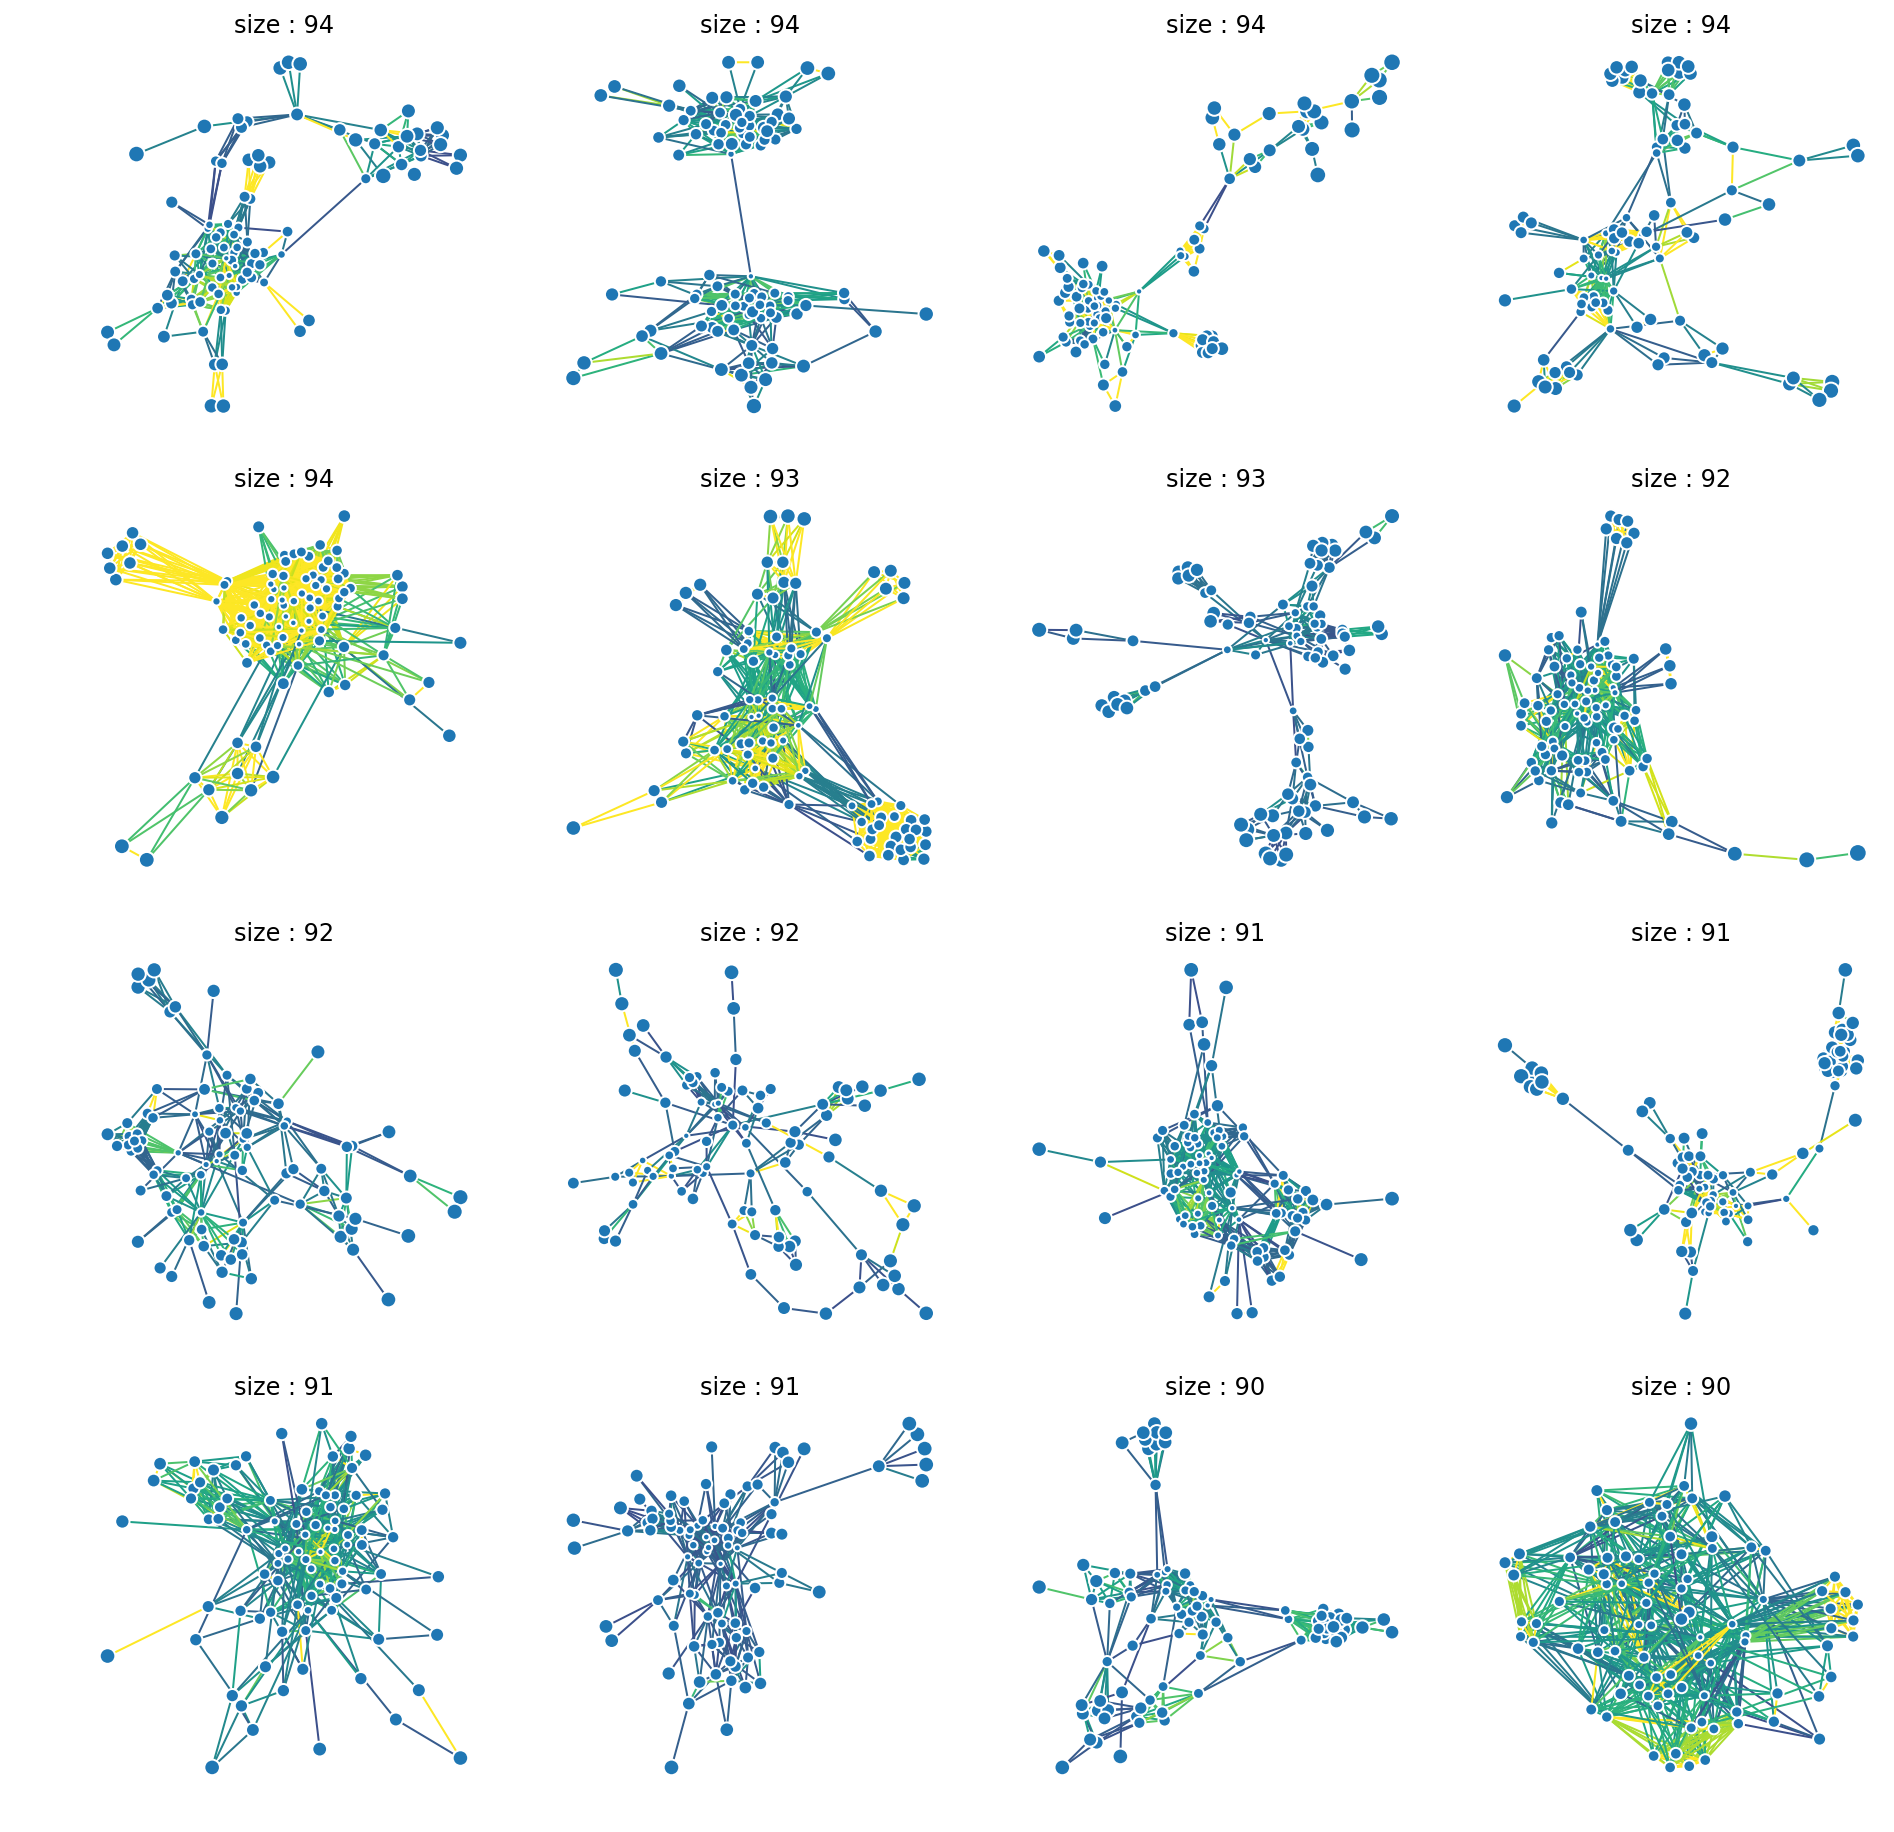

In [6]:
from grave import plot_network, use_attributes

figure( figsize = ( 16, 16 ) )

#def edge_style(edge_attrs):
#
#    alpha = edge_attrs['weight'] / 1000
#    return {'color' : 'black', 'alpha' : alpha }

def edge_style( edge_attributes ):
    return { 'linewidth' : edge_attributes.get( 'bit score', 1 ) }

for n,g in enumerate(components[ 200:216 ]) :
    subplot( 4, 4, n+1 )
    title( ' : '.join( map( str, ('size', len(g) ) ) ) )
    
    centrality = networkx.closeness_centrality( g )
    max_centrality = max( centrality.values() )
    
    for node, node_attributes in g.nodes.data():
        node_attributes['size'] = ( 1 - ( centrality[node] /
                                    max_centrality) + .1 ) * 100
    
    
    for u, v, edge_attributes in g.edges.data():
        #c = (centrality[u] +
        #     centrality[v]) / 2
        #color_idx = (c / max_centrality)
        color_idx = ( edge_attributes['bit score'] / bit_med )
        cmap = get_cmap()
        edge_attributes['color'] = cmap(color_idx)
        edge_attributes['width'] = 2
    
    #grave.plot_network( g, layout='spring', edge_style=edge_style )
    plot_network( g, layout='spring',
                  node_style=use_attributes(),
                  edge_style=use_attributes('color') )

## Phylogeography

#### Build phylogenetic trees from full-length alignments of protein families

We already have pairwise-alignments of our protein sequences from LAST, but now we want
multiple sequence alignments for each of the protein families using
[Clustal Omega](http://www.clustal.org/omega/). We'll use the MSAs to build approximate 
maximum likelihood trees using [`fasttree`](http://www.microbesonline.org/fasttree/).

In [13]:
import subprocess
from os.path import splitext
from os import environ

def clustalo( fasta_file, threads=1 ) :
    
    base = splitext(fasta_file)[0]
    alignment_file = base + '_clustalo.fasta'
    log_file = base + '_clustalo.log'

    args = ['clustalo', '-v', '--force',
            '-i', fasta_file,
            '--outfmt=fasta',
            '--threads=' + str(threads),
            '-o', alignment_file,
            '-l', log_file ]

    subprocess.call( args )
    return alignment_file


def fasttree( alignment_file, threads=1 ) :
    
    base = splitext(alignment_file)[0]
    tree_file = base + '_fasttree.tree'
    log_file = base + '_fasttree.log'
    
    e = environ
    e['OMP_NUM_THREADS'] = str(threads)
    
    args = ['FastTreeMP', '-gtr', '-log', log_file ] 

    with open( tree_file, 'w' ) as outfile:
        with open( alignment_file, 'r' ) as infile:
            proc = subprocess.Popen( args, env=e, stdout=outfile, stdin=infile )
            proc.wait()
    
    return tree_file

In [ ]:
from tempfile import mkdtemp

N = 100000
progbar = pyprind.ProgBar( N-1, title='building trees for protein families...' )

treefiles = []
scratch = mkdtemp()
    
for n,g in enumerate( components[:N] ) :
    
    # skip the giant hairball
    if n == 0 : continue
    
    progbar.update()   
    fasta = scratch + '/' + str(n) + '.fa'
    
    with open( fasta, 'w' ) as f :
        
        # generate FASTA file for protein family
        for node in g.nodes :
            f.write( '> ' + str(node) + '\n' + str(viralgenes[node].sequence) + '\n' )
        
    # build alignment and 
    treefiles.append( fasttree( clustalo( fasta, threads=40 ), threads=40 ) )

building trees for protein families...
0% [##########                    ] 100% | ETA: 14:27:37

In [7]:
# uncomment if trees have already been constructed
treefiles = [ 'scratch/familes/{n}_clustalo_fasttree.tree'.format(n=n) for n in range(1,100000) ]

progbar = pyprind.ProgBar( len(treefiles), title='loading trees for protein families...' )

trees = []

for treefile in treefiles :
    progbar.update()
    trees.append( SuchTree( treefile ) )

loading trees for protein families...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:10:21


#### Load sample and mVC metadata

The metadata table contains some mVC's (metagenomic viral contigs, or putative viral genomes)
that we don't actually want because they come from samples that are not soil. So, we need to
remove them from the table before we continue.

In [8]:
metadata = pandas.read_csv( 'data/metadata.csv', sep=',', index_col=0, low_memory=False )

print( 'total records :', metadata.shape[0] )

filtered_mVCs = []
for line in open( 'data/soil_contigs.txt' ).readlines() :
    filtered_mVCs.append( line.replace( '.a:', '_____' ).strip() )
    
print( 'records to drop :', len( set( metadata.index ) ^ set( filtered_mVCs ) ) )

metadata = metadata.drop( set( metadata.index ) ^ set( filtered_mVCs ), axis=0 )
print( 'records retained :', metadata.shape[0] )

total records : 36384
records to drop : 12050
records retained : 24334


#### Extract sample geolocations

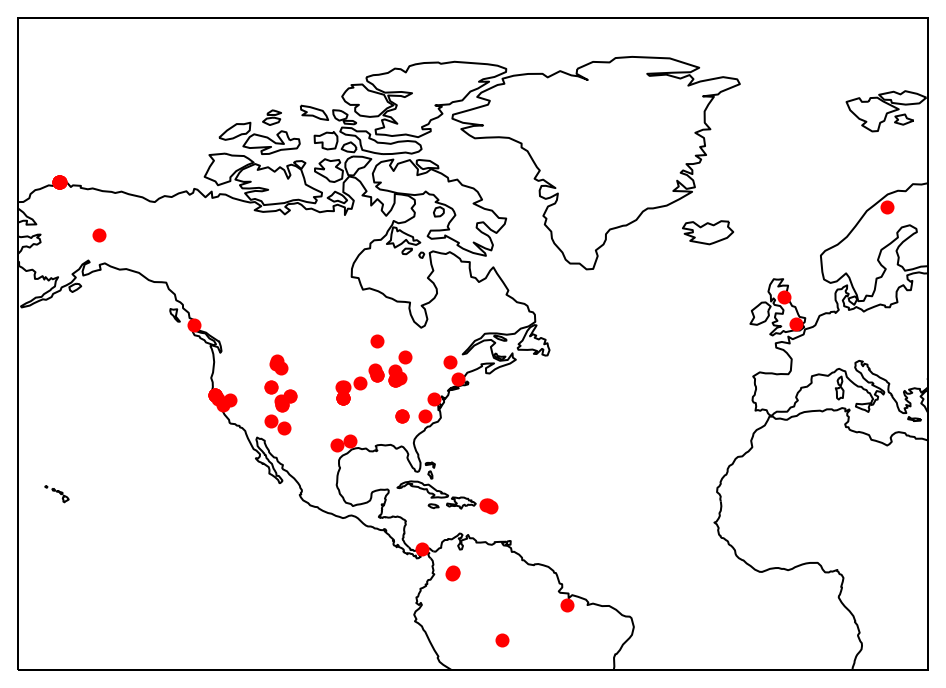

In [181]:
figure( figsize=(12,6) )

# this is kinda horrible, but whatever
locstrings = set( ','.join( (str(a),str(b)) ) for a,b in zip( list( metadata.Latitude ), 
                                                              list( metadata.Longitude ) ) ) 

locations = []
for locstring in locstrings :
    lat, lon = locstring.split(',')
    if lat == 'nan' : continue
    locations.append( [ float(lon), float(lat) ] )

ax = plt.axes( projection=cartopy.crs.Miller() )
#ax.add_image( GoogleTiles( style='satellite' ), 3 )
ax.coastlines()

locations_table = pandas.DataFrame(locations, columns=['x','y'])

x, y = zip(*locations)
plot( x, y, 'ro', transform=cartopy.crs.Geodetic() )
savefig( 'soilvirome_map.png' )
savefig( 'soilvirome_map.pdf' )

      bio1 bio2 bio3  bio4 bio5 bio6 bio7 bio8 bio9 bio10 bio11 bio12 bio13
 [1,]  110  145   53  4500  274    1  273   61  169   170    57  1565   287
 [2,]  256   87   71  1251  313  192  121  269  238   269   238  1776   191
 [3,]   84   42   29  3644  161   20  141   64  131   133    41  2924   375
 [4,]   86  112   29  9680  284 -100  384  197  -30   206   -44   914    99
 [5,]  126  118   33  8523  305  -50  355  213   13   233    13  1044   102
 [6,]  110  145   53  4500  274    1  273   61  169   170    57  1565   287
 [7,]   80  178   40  8867  311 -131  442  146  -14   193   -37   353    35
 [8,]  110  145   53  4500  274    1  273   61  169   170    57  1565   287
 [9,]  101  203   52  6846  300  -85  385  186  131   191    16   475    85
[10,]  195  122   38  6920  351   32  319  233  118   281   103   835   113
[11,]  143  125   36  7883  310  -28  338   55  201   242    39  1278   135
[12,]  141  124   36  7913  308  -31  339   52  199   240    36  1274   132
[13,]   97  

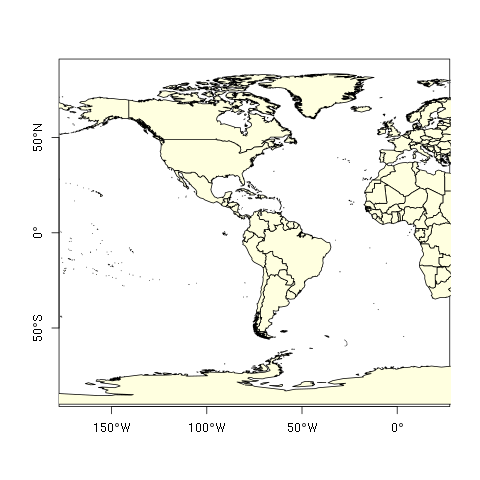

In [139]:
%%R -i locations_table

library(dismo)
library(maptools)
library(raster)
library(sp)
data(wrld_simpl)
plot(wrld_simpl, xlim=c(-170,20), ylim=c(-10,10), axes=TRUE, col="light yellow")
# restore the box around the map
#box()

#lt <- coordinates(locations_table)

files <- list.files(path=paste(system.file(package="dismo"), '/ex' , sep= '' ), pattern= 'grd' , full.names=TRUE )
#predictors <- stack(files)

#randomPoints(predictors, 50)
#data.matrix(locations_table)


extract(climate, data.matrix( locations_table ) )

#extract(predictors, locations_table)
#presvals

#coordinates(locations_table) <- ~lat+lon

#raster( locations_table )

#plot( predictors, 9 )
# plot points
#points(locations_table$x, locations_table$y, col= 'orange' , pch=20, cex=0.75)
# plot points again to add a border, for better visi
#points(locations_table$x, locations_table$y, col= 'red' , cex=0.75)



#library(stringi)

#stri_list2matrix(locations)




In [137]:
%%R

climate <- getData('worldclim', var='bio', res=2.5)

/global/homes/r/ryneches/opt/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://biogeo.ucdavis.edu/data/climate/worldclim/1_4/grid/cur/bio_2-5m_bil.zip'

  warnings.warn(x, RRuntimeWarning)
/global/homes/r/ryneches/opt/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Content type 'application/zip'
  warnings.warn(x, RRuntimeWarning)
/global/homes/r/ryneches/opt/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 129319755 bytes (123.3 MB)

  warnings.warn(x, RRuntimeWarning)
/global/homes/r/ryneches/opt/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: =
  warnings.warn(x, RRuntimeWarning)
/global/homes/r/ryneches/opt/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)
/global/homes/r/ryneches/opt/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 12

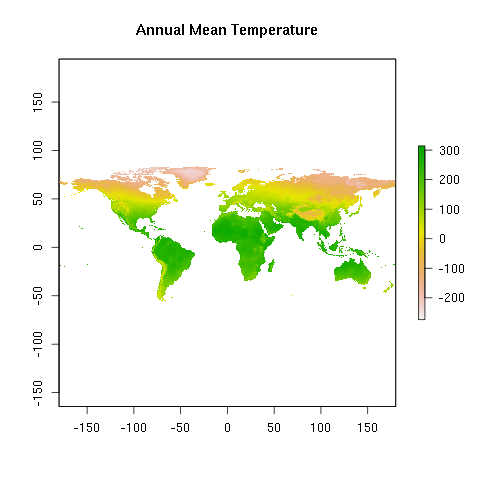

In [138]:
%%R

plot(climate$bio1, main="Annual Mean Temperature")

#### Haversine (great circle) distances

In [12]:
from math import radians, cos, sin, asin, sqrt
from itertools import combinations

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    
    https://stackoverflow.com/questions/4913349/#4913653    
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def geo_distance_pairs( tree, gradient='full' ) :
    node_locations = {}
    for node in tree.leafs.keys() :
        mVC = '_____'.join( node.split('_____')[:2] )
        #if mVC in metadata.index : continue
        lat = metadata.loc[ mVC ].Latitude
        lon = metadata.loc[ mVC ].Longitude
        #if isnan(lat) or isnan(lon) : continue
        node_locations[node] = ( lat, lon )

    for node1, node2 in combinations( tree.leafs.keys(), 2 ) :
        lat1, lon1 = node_locations[ node1 ]
        lat2, lon2 = node_locations[ node2 ]
        if gradient == 'full' :
            yield haversine(lon1, lat1, lon2, lat2)
        elif gradient == 'lat' :
            yield haversine(0, lat1, 0, lat2)
        elif gradient == 'lon' :
            yield haversine(lon1, 0, lon2, 0)

#### Calculate haversine and phylogenetic distances

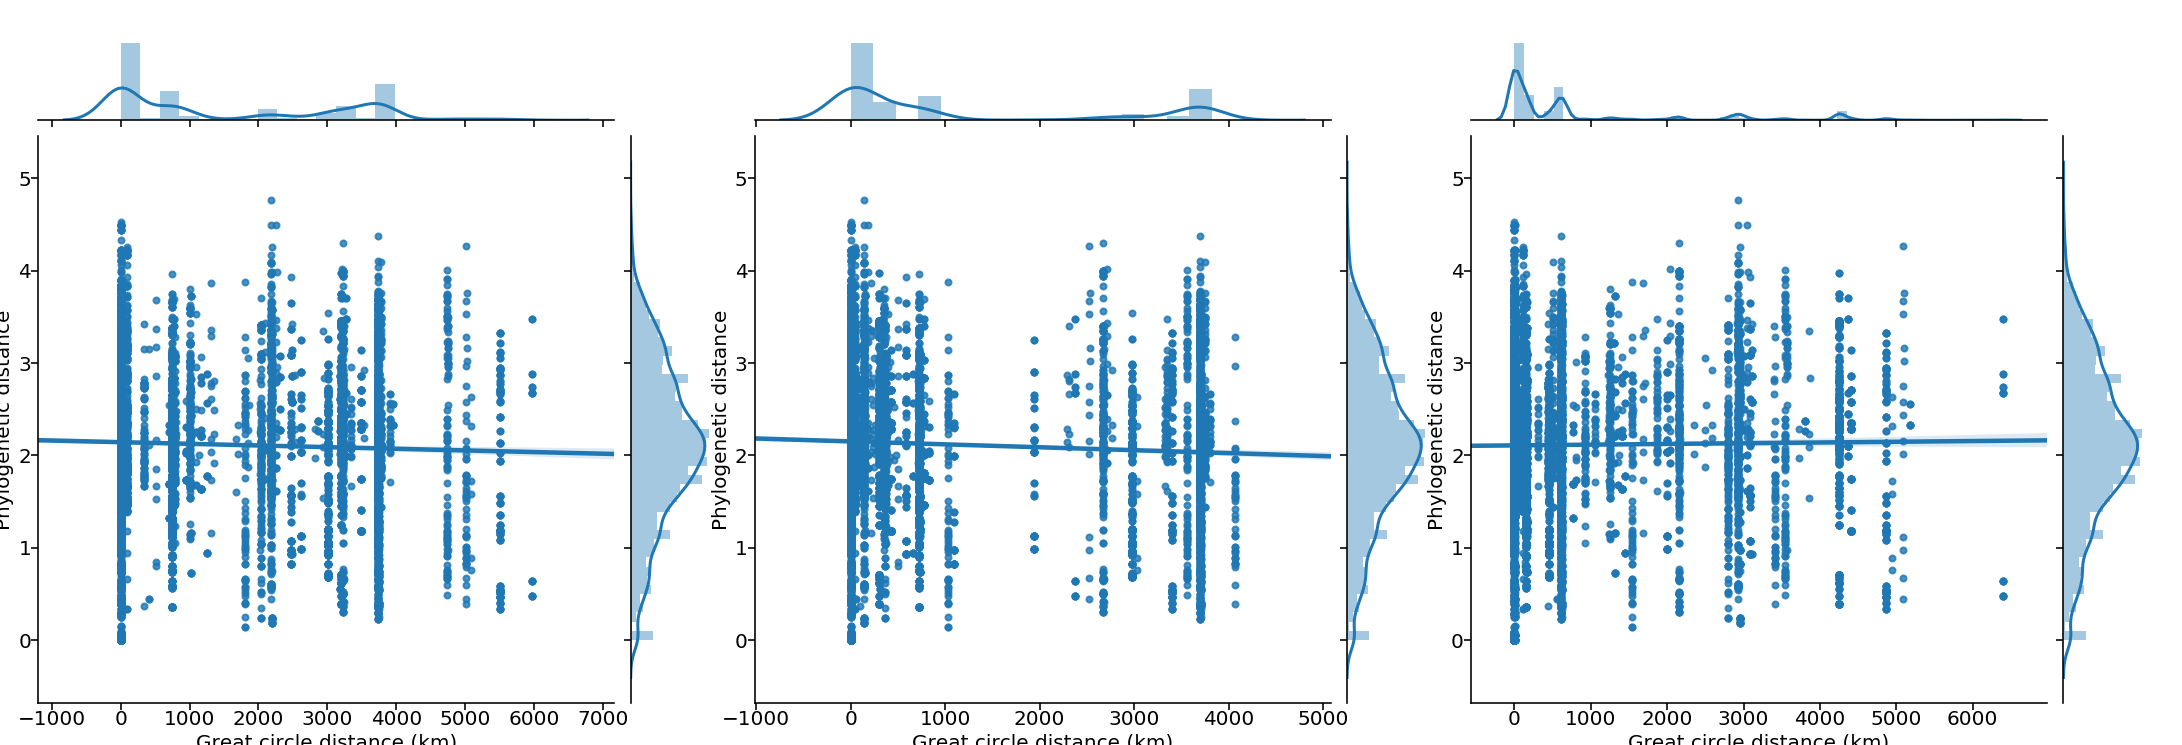

In [13]:
from itertools import combinations
import SeabornFig2Grid as sfg
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(30,10))
gs = gridspec.GridSpec(1, 3)

tree = trees[104]
phylodist = tree.distances_by_name( list( combinations( tree.leafs.keys(), 2 ) ) )

geodist = list( geo_distance_pairs( tree, gradient='full' ) )

g0 = seaborn.jointplot( geodist, phylodist, kind='reg' )
g0.set_axis_labels( xlabel='Great circle distance (km)',
                    ylabel='Phylogenetic distance' )

geodist = list( geo_distance_pairs( tree, gradient='lat' ) )

g1 = seaborn.jointplot( geodist, phylodist, kind='reg' )
g1.set_axis_labels( xlabel='Great circle distance (km)',
                    ylabel='Phylogenetic distance' )

geodist = list( geo_distance_pairs( tree, gradient='lon' ) )

g2 = seaborn.jointplot( geodist, phylodist, kind='reg' )
g2.set_axis_labels( xlabel='Great circle distance (km)',
                    ylabel='Phylogenetic distance' )

mg0 = sfg.SeabornFig2Grid(g0, fig, gs[0])
mg1 = sfg.SeabornFig2Grid(g1, fig, gs[1])
mg2 = sfg.SeabornFig2Grid(g2, fig, gs[2])

gs.tight_layout(fig)

In [14]:
progbar = pyprind.ProgBar( len(trees), title='calculating geographic and phylogenetic distances for protein families...' )

distances = []
distances_ns = []
distances_ew = []
for tree in trees :
    progbar.update()
    
    geodist    = list( geo_distance_pairs( tree, gradient='full' ) )
    geodist_ns = list( geo_distance_pairs( tree, gradient='lat'  ) )
    geodist_ew = list( geo_distance_pairs( tree, gradient='lon'  ) )
    
    phylodist = tree.distances_by_name( list( combinations( tree.leafs.keys(), 2 ) ) )
    
    # drop cases where the geographic distance is undefined
    gd    = delete( geodist,    argwhere( isnan( geodist    ) ) )
    gd_ns = delete( geodist_ns, argwhere( isnan( geodist_ns ) ) )
    gd_ew = delete( geodist_ew, argwhere( isnan( geodist_ew ) ) )
    
    pd    = delete( phylodist, argwhere( isnan(geodist) ) )
    
    distances.append(    ( gd,    pd ) )
    distances_ns.append( ( gd_ns, pd ) )
    distances_ew.append( ( gd_ew, pd ) )

calculating geographic and phylogenetic distances for protein families...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:09:40


#### Calculate correlations between haversine and phylogenetic distances, correct p-values for multiple tests 

We use Kendall's $\tau$ rank-order correlation because we cannot assume that the distributions
of either distance measure will be normal. Then, we apply the 
[Simes-Hochberg](https://en.wikipedia.org/wiki/Family-wise_error_rate) step-up procedure to correct
the p-values for multiple  tests.


In [15]:
from scipy.stats import pearsonr, kendalltau
from statsmodels.stats.multitest import multipletests

correlations    = pandas.DataFrame( kendalltau(a,b) for a,b in distances    )

correlations['size'] = [ tree.n_leafs for tree in trees ]
correlations['total_pd'] = [ sum( tree.adjacency()['adjacency_matrix'] ) / 2.0 for tree in trees ]
correlations['aspect'] = [ sum( tree.adjacency()['adjacency_matrix'] ) / ( 2.0 * tree.n_leafs ) for tree in trees ]

reject, corrected_p, alphacSidak, alphacBonf = multipletests( correlations.dropna().pvalue, 
                                                              alpha=0.05,
                                                              method='simes-hochberg' )

correlations['reject'] = pandas.DataFrame( reject, index=correlations.dropna().index )
correlations['corrected_p'] = pandas.DataFrame( corrected_p, index=correlations.dropna().index )

correlations_ns = pandas.DataFrame( kendalltau(a,b) for a,b in distances_ns )
correlations_ew = pandas.DataFrame( kendalltau(a,b) for a,b in distances_ew )
correlations_ns.columns = [ 'correlation_ns', 'pvalue_ns' ]
correlations_ew.columns = [ 'correlation_ew', 'pvalue_ew' ]

correlations = correlations.join( correlations_ns ).join( correlations_ew )

print( 'protein families with statisticailly significant phylogeography :', 
       correlations[ correlations.reject == True ].shape[0] )

# don't forget that we're ignoring the big hairball (component 0)
correlations['component'] = range(1,100000)
correlations = correlations.set_index('component')

correlations.head()

protein families with statisticailly significant phylogeography : 1046


correlation        pvalue  size     total_pd    aspect reject  \
component                                                                  
1             0.018191  0.000000e+00  2155  1044.263096  0.484577   True   
2             0.003343  3.402891e-05  1235   272.664585  0.220781  False   
3            -0.007430  2.341252e-09   799   419.746406  0.525340   True   
4            -0.016409  1.152977e-31   699   308.844802  0.441838   True   
5             0.028218  1.917933e-76   644   267.364178  0.415162   True   

            corrected_p  correlation_ns      pvalue_ns  correlation_ew  \
component                                                                
1          0.000000e+00        0.014549  1.806028e-212        0.011868   
2          5.718559e-01        0.014160   5.158468e-69       -0.002174   
3          4.139568e-05        0.005710   4.438553e-06       -0.017567   
4          2.093460e-27       -0.015295   9.950650e-28       -0.019994   
5          3.494857e-72        0.044203  9.858231e-185        0.003472   

               pvalue_ew  
component                 
1          4.590670e-142  
2           7.024487e-03  
3           2.864949e-45  
4           3.548347e-46  
5           2.278425e-02

Let's look at the distribution of correlations for the protein families where we can
reject the null hypothesis.

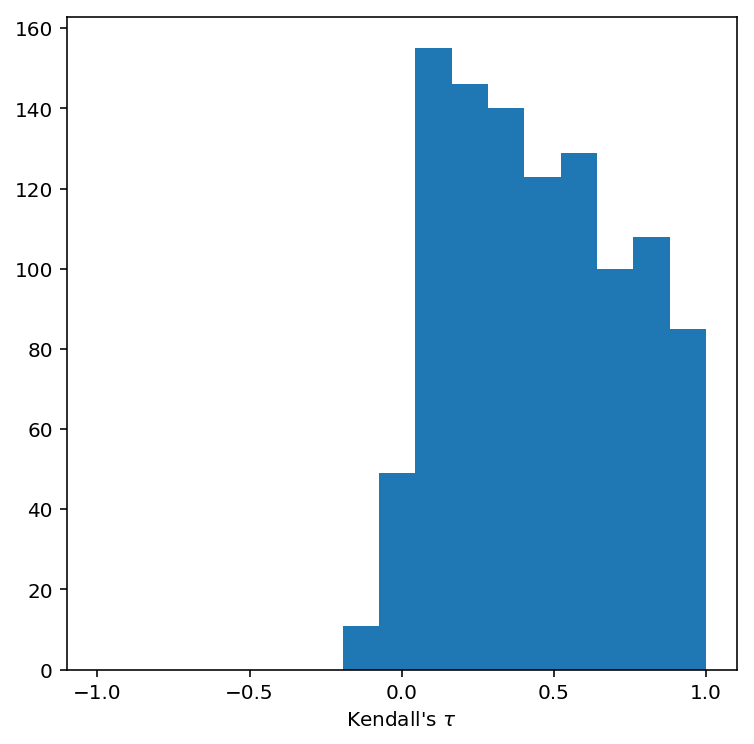

In [16]:
figure( figsize=(6,6) )

#seaborn.distplot( correlations[ correlations.reject == True ].correlation, norm_hist=False )
hist( correlations[ correlations.reject == True ].correlation )
xlabel( r"Kendall's $\tau$" )
xlim( -1.1, 1.1 )
xticks( [-1, -0.5, 0.0, 0.5, 1 ])

savefig( 'correlations_histogram.svg' )

In [18]:
from scipy.stats import linregress

d = correlations[ (correlations.reject == True) & (correlations.correlation < 1 ) ][ ['correlation', 'aspect'] ]

print( d.head(), '\n' )

slope, intercept, r_value, p_value, std_err = linregress( d.correlation, d.aspect )

print( 'slope     : {slope}'.format(   slope   = slope      ) )
print( 'intercept : {i}'.format(       i       = intercept  ) )
print( 'R^2       : {r2}'.format(      r2      = r_value**2 ) )
print( 'p         : {p}'.format(       p       = p_value    ) )
print( 'sterr     : {std_err}'.format( std_err = std_err    ) )

           correlation    aspect
component                       
1             0.018191  0.484577
3            -0.007430  0.525340
4            -0.016409  0.441838
5             0.028218  0.415162
6             0.070936  0.460640 

slope     : -0.2961242309670162
intercept : 0.473652476459147
R^2       : 0.2029618688272764
p         : 7.61730707376101e-51
sterr     : 0.01863161205265664


<Figure size 432x432 with 0 Axes>

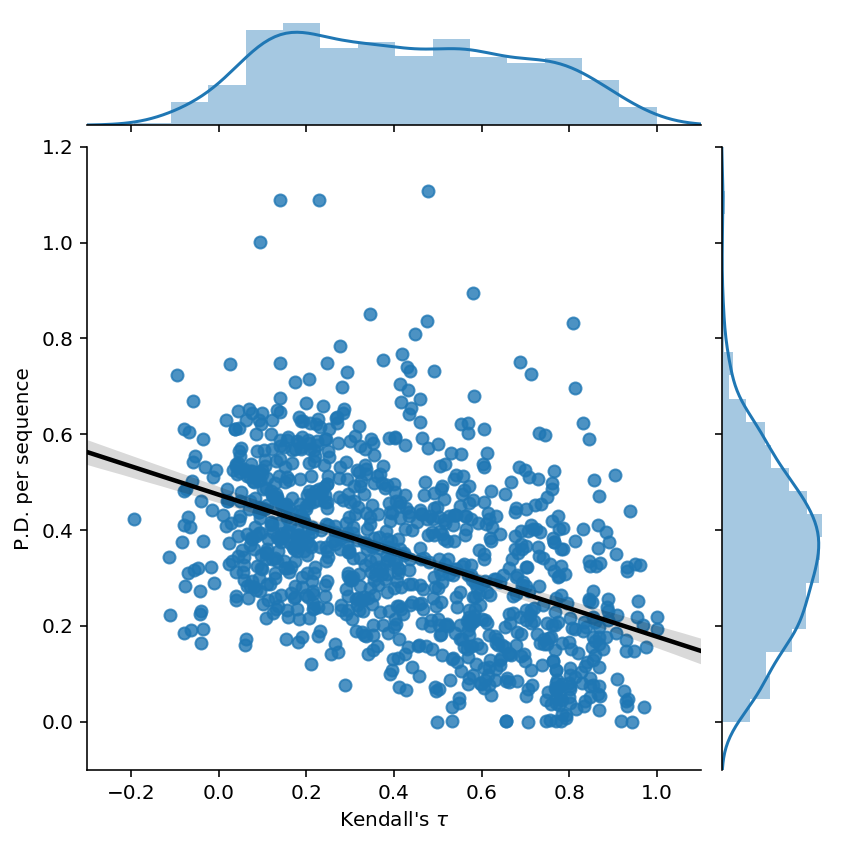

In [76]:
figure( figsize=(6,6) )

seaborn.jointplot( y='aspect', x='correlation', data=d,
                   kind='reg', line_kws={'color':'black'},
                   fit_reg=True )

xlabel( r"Kendall's $\tau$" )
ylabel( 'P.D. per sequence')

ylim( -0.1, 1.2 )
xlim( -0.3, 1.1 )

savefig( 'correlations_histogram.svg' )
savefig( 'fig3c.pdf' )

Protein families with a higher aspect ratio (total phylogenetic distance per member) tend to have lower
correlations between their geographic distance and phylogenetic distances. This suggests that the biogeography
of viral protein families is driven by founder effects, not allopatric speciation.

## Functional profiles of viral protein families

In [20]:
with open( 'data/genes_vs_pfams.txt' ) as f :
    pfam_hits = {}
    gene_hits = {}
    for line in f.readlines() :
        gene = '_____'.join( line.split()[:3] )
        if len( line.split() ) <= 3 : continue
        pfams = [ pfam.replace('pfam','PF') for pfam in line.split()[3].split(',') ]
        pfam_hits[gene] = pfams
        for pfam in pfams :
            if not pfam in gene_hits :
                gene_hits[pfam] = []
            gene_hits[pfam].append( gene )

all_hits = []
for n,tree in enumerate(trees) :
    pfams = []
    for gene in tree.leafs.keys() :
        if gene in pfam_hits :
            pfams.extend( pfam_hits[gene] )
    all_hits.append(pfams)

How many of our viral protein families are totally novel, at least as far as Pfam is concerned?

In [21]:
sum( len(set(hits)) == 0 for hits in all_hits ) / sum(len(all_hits))

0.9012490124901249

Wow! That's most of them! Well, let's have a look at some of the ones that have annotations.

In [22]:
names=['Pfam accession', 'clan accession', 'clan ID', 'Pfam ID', 'Pfam description']
usecols=['Pfam accession', 'Pfam ID', 'Pfam description']
pfam_table = pandas.read_csv( 'data/Pfam-A.clans.tsv', sep='\t', names=names, usecols=usecols )
pfam_table.head()

Pfam accession   Pfam ID                                   Pfam description
0        PF00001     7tm_1        7 transmembrane receptor (rhodopsin family)
1        PF00002     7tm_2         7 transmembrane receptor (Secretin family)
2        PF00003     7tm_3     7 transmembrane sweet-taste receptor of 3 GCPR
3        PF00004       AAA  ATPase family associated with various cellular...
4        PF00005  ABC_tran                                    ABC transporter

In [23]:
for row in pfam_table[ pfam_table['Pfam description'].str.contains('glycoside') ].values :
    pfam = row[0]
    if pfam in gene_hits :
        samples = []
        for gene in gene_hits[pfam] :
            samples.append( '_____'.join( gene.split('_____')[:2] ) )
        print(pfam, samples)

PF04655 ['3300005336_____Ga0070680_100000178']
PF14323 ['3300012357_____Ga0137384_10000154']


In [24]:
pfam_table[ pfam_table['Pfam description'].str.contains('glycoside') ]

Pfam accession          Pfam ID  \
2340         PF02522   Antibiotic_NAT   
4302         PF04655        APH_6_hur   
9932         PF10706  Aminoglyc_resit   
13447        PF14323        GxGYxYP_C   
13988        PF14872             GHL5   
15232        PF16141          DUF4849   

                                        Pfam description  
2340                Aminoglycoside 3-N-acetyltransferase  
4302   Aminoglycoside/hydroxyurea antibiotic resistan...  
9932              Aminoglycoside-2''-adenylyltransferase  
13447  GxGYxYP putative glycoside hydrolase C-termina...  
13988                 Hypothetical glycoside hydrolase 5  
15232  Putative glycoside hydrolase Family 18, chitin...

In [25]:
pfam_table.loc[13447]['Pfam description']

'GxGYxYP putative glycoside hydrolase C-terminal domain'

In [133]:
antitoxins = []

for n,row in pfam_table[ pfam_table['Pfam description'].str.contains('antitoxin') ].iterrows() :
    pfam = row['Pfam accession']
    if pfam in gene_hits :
        samples = []
        for gene in gene_hits[pfam] :
            samples.append( '_____'.join( gene.split('_____')[:2] ) )
        row[ 'Hits' ] = len(samples)
        row[ 'Samples' ] = ','.join( samples )
        antitoxins.append(row)

antitoxins = pandas.DataFrame( antitoxins )

antitoxins.to_csv( 'toxin_antitoxin_hits.csv' )

antitoxins

Pfam accession          Pfam ID  \
2274         PF02452       PemK_toxin   
2412         PF02604  PhdYeFM_antitox   
2492         PF02697     VAPB_antitox   
3409         PF03693   ParD_antitoxin   
3716         PF04014   MazE_antitoxin   
3905         PF04221             RelB   
4037         PF04365       BrnT_toxin   
4642         PF05015  HigB-like_toxin   
4643         PF05016       ParE_toxin   
5817         PF06296             RelE   
6242         PF06769       YoeB_toxin   
6775         PF07362             CcdA   
7305         PF07927       HicA_toxin   
7551         PF08178      GnsAB_toxin   
8186         PF08845       SymE_toxin   
9196         PF09907       HigB_toxin   
9239         PF09957   VapB_antitoxin   
10120        PF10899            AbiGi   
11097        PF11903        ParD_like   
11623        PF12441   CopG_antitoxin   
12078        PF12910         PHD_like   
12500        PF13338          AbiEi_4   
13087        PF13955        Fst_toxin   
13089        PF13957       YafO_toxin   
13145        PF14013   MT0933_antitox   
13508        PF14384   BrnA_antitoxin   
14833        PF15731   MqsA_antitoxin   
14840        PF15738       YafQ_toxin   
15015        PF15919  HicB_lk_antitox   
15039        PF15943   YdaS_antitoxin   
15065        PF15970      HicB-like_2   

                                        Pfam description  Hits  \
2274   PemK-like, MazF-like toxin of type II toxin-an...    34   
2412   Antitoxin Phd_YefM, type II toxin-antitoxin sy...    64   
2492                                  Putative antitoxin     6   
3409   Bacterial antitoxin of ParD toxin-antitoxin ty...     5   
3716   Antidote-toxin recognition MazE, bacterial ant...    23   
3905                                      RelB antitoxin     8   
4037   Ribonuclease toxin, BrnT, of type II toxin-ant...    11   
4642   RelE-like toxin of type II toxin-antitoxin sys...    20   
4643   ParE toxin of type II toxin-antitoxin system, ...    33   
5817    RelE toxin of RelE / RelB toxin-antitoxin system     4   
6242   YoeB-like toxin of bacterial type II toxin-ant...    19   
6775                     Post-segregation antitoxin CcdA     1   
7305           HicA toxin of bacterial toxin-antitoxin,     65   
7551   GnsA/GnsB toxin of bacterial toxin-antitoxin s...     1   
8186           Toxin SymE, type I toxin-antitoxin system    10   
9196   HigB_toxin, RelE-like toxic component of a tox...     3   
9239      Bacterial antitoxin of type II TA system, VapB     3   
10120  Putative abortive phage resistance protein Abi...     1   
11097  ParD-like antitoxin of type II bacterial toxin...     8   
11623  CopG antitoxin of type II toxin-antitoxin system      1   
12078  Antitoxin of toxin-antitoxin, RelE / RelB, TA ...     1   
12500         Transcriptional regulator, AbiEi antitoxin     2   
13087           Toxin Fst, type I toxin-antitoxin system     1   
13089         Toxin YafO, type II toxin-antitoxin system     2   
13145                      MT0933-like antitoxin protein     1   
13508   BrnA antitoxin of type II toxin-antitoxin system    13   
14833  Antitoxin component of bacterial toxin-antitox...     1   
14840  Bacterial toxin of type II toxin-antitoxin sys...     3   
15015  HicB_like antitoxin of bacterial toxin-antitox...    14   
15039  Putative antitoxin of bacterial toxin-antitoxi...   111   
15065  HicB_like antitoxin of bacterial toxin-antitox...     2   

                                                 Samples  
2274   2162886008_____PRSSGFe2_Sequence0000000158,330...  
2412   2162886015_____FOassembled-_contig00006,216288...  
2492   3300002183_____JGI24145J26757_10000041,3300002...  
3409   3300005330_____Ga0070690_100000956,3300005530_...  
3716   3300001868_____JGI24146J20443_1000224,33000021...  
3905   2189573022_____PRSSG2_Sequence0000000899,33000...  
4037   2162886007_____SwRhRL2b_contig_440006,33000009...  
4642   3300001990_____JGI24737J22298_10000131,3300005...  
4643   2088090015_____GPICI_5395867,2124908039___

In [26]:
vfam_pfams = []
for n,g in enumerate( components ) :
    pfams = []
    for gene in g.nodes :
        if gene in pfam_hits :
            pfams.extend( pfam_hits[gene] )
    vfam_pfams.append(pfams)

In [27]:
#sorted( [ len(vfam) for vfam in vfam_pfams ], reverse=True )
#[ len(vfam) for vfam in vfam_pfams ].index(1232)

dead_pfams = set()
with open( 'data/Pfam-A.dead' ) as f :
    for line in f.readlines() :
        if line.startswith( '#=GF AC' ) :
            dead_pfams.add( line.split()[2] )
            
def is_pfam_alive( pfam_id ) :
    return pfam_id in dead_pfams

def most_common( lst, dead ) :
    extant_pfams = set(lst) - set(dead)
    if extant_pfams :
        return max( extant_pfams, key=lst.count )
    else :
        return None
    
def pfam_annotation( vfam_index ) :
    if vfam_index > len( vfam_pfams ) - 1 :
        return 'Viral family too small'
    pfam = most_common( vfam_pfams[vfam_index], dead_pfams )
    if pfam :
        return pfam_table[ pfam_table['Pfam accession'] == pfam ]['Pfam description'].values[0]
    else :
        return 'Novel protein family'

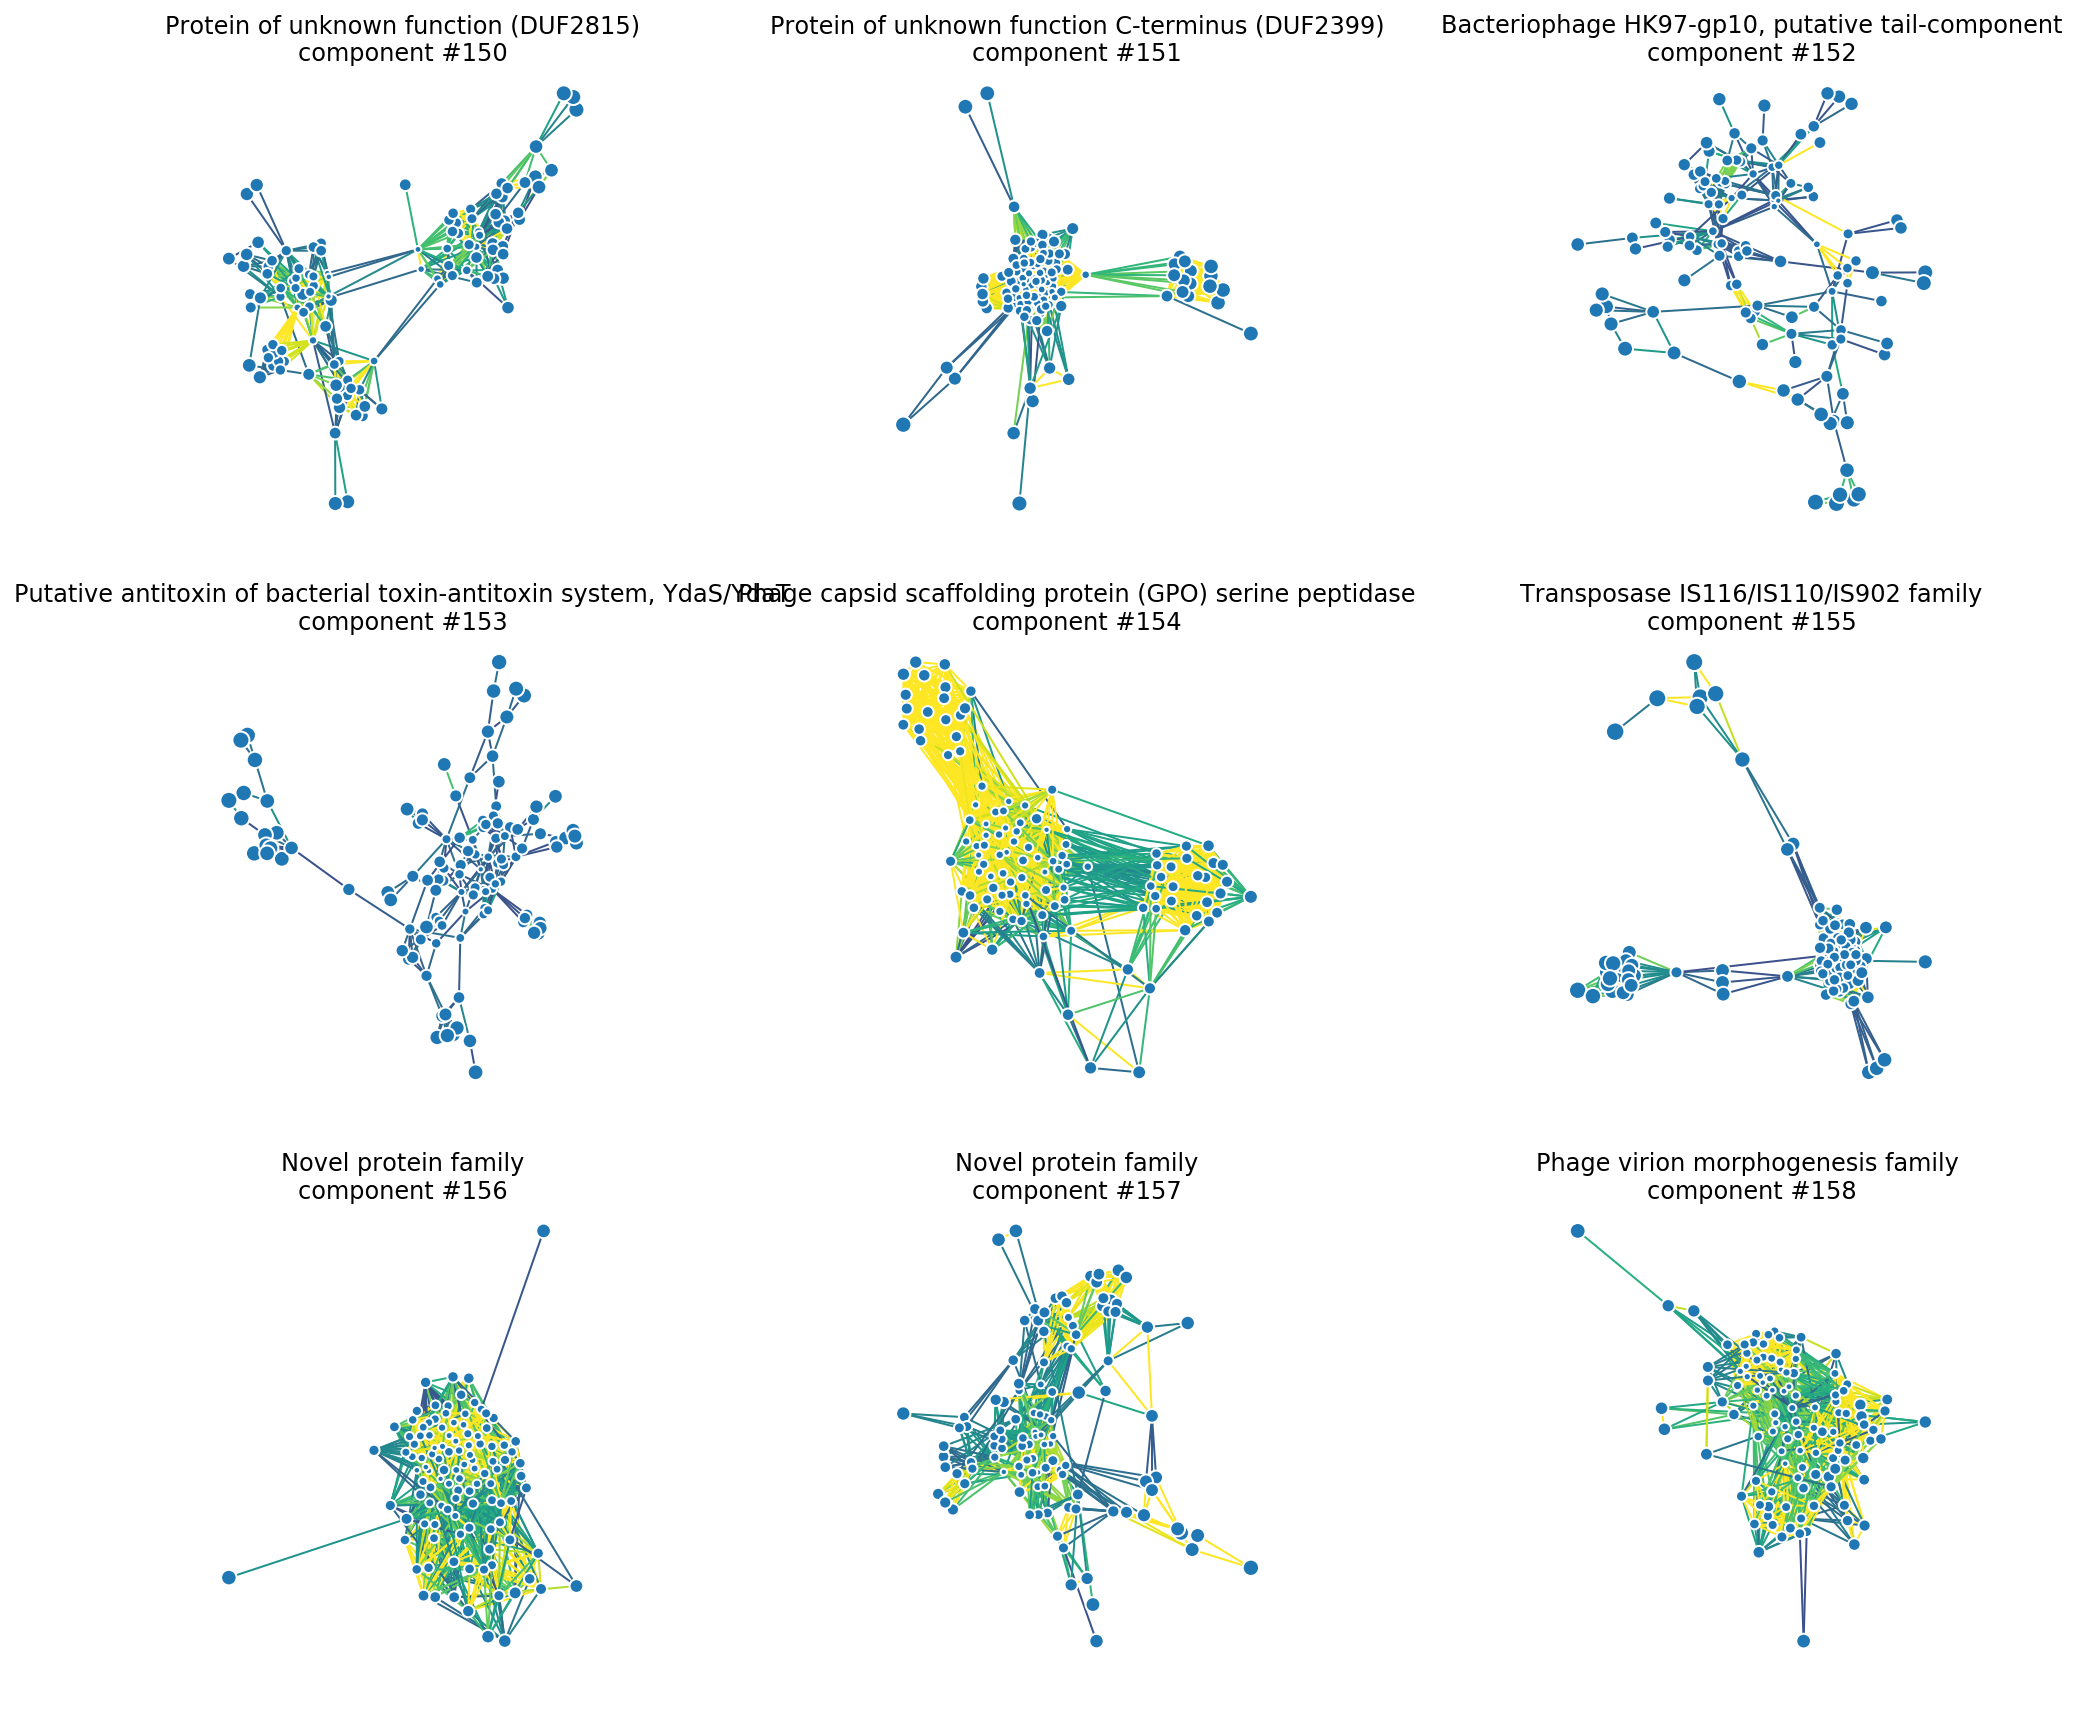

In [28]:
from grave import plot_network, use_attributes

#figure( figsize = ( 16, 16 ) )
figure( figsize = ( 14, 12 ) )

#def edge_style(edge_attrs):
#
#    alpha = edge_attrs['weight'] / 1000
#    return {'color' : 'black', 'alpha' : alpha }

def edge_style( edge_attributes ):
    return { 'linewidth' : edge_attributes.get( 'bit score', 1 ) }

for n,i in enumerate( range( 150, 150+9 ) ) :
    g = components[i]
    subplot( 3, 3, n+1 )
    #title( ' : '.join( map( str, ('size', len(g) ) ) ) )
    title( pfam_annotation(i) + '\ncomponent #' + str(i) )
    
    centrality = networkx.closeness_centrality( g )
    max_centrality = max( centrality.values() )
    
    for node, node_attributes in g.nodes.data():
        node_attributes['size'] = ( 1 - ( centrality[node] /
                                    max_centrality) + .1 ) * 100
    
    
    for u, v, edge_attributes in g.edges.data():
        #c = (centrality[u] +
        #     centrality[v]) / 2
        #color_idx = (c / max_centrality)
        color_idx = ( edge_attributes['bit score'] / bit_med )
        cmap = get_cmap()
        edge_attributes['color'] = cmap(color_idx)
        edge_attributes['width'] = 2
    
    #grave.plot_network( g, layout='spring', edge_style=edge_style )
    plot_network( g, layout='spring',
                  node_style=use_attributes(),
                  edge_style=use_attributes('color') )
tight_layout()
savefig( 'connected_components.svg' )

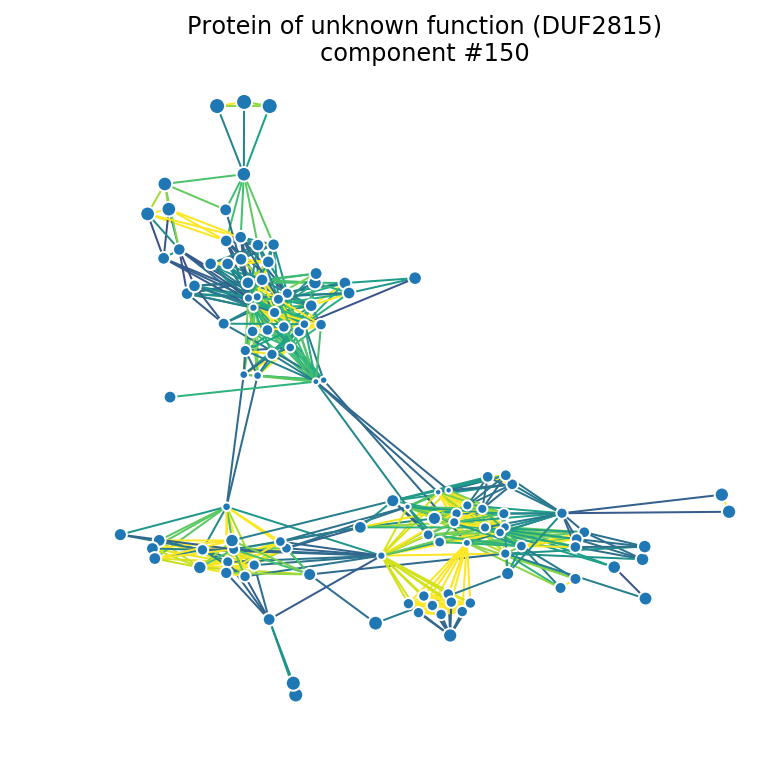

In [40]:
# Figure graphic

figure( figsize=(6,6) )

i = 150

g = components[i]
title( pfam_annotation(i) + '\ncomponent #' + str(i) )

centrality = networkx.closeness_centrality( g )
max_centrality = max( centrality.values() )

for node, node_attributes in g.nodes.data():
    node_attributes['size'] = ( 1 - ( centrality[node] /
                                max_centrality) + .1 ) * 100
    
for u, v, edge_attributes in g.edges.data():
    color_idx = ( edge_attributes['bit score'] / bit_med )
    cmap = get_cmap()
    edge_attributes['color'] = cmap(color_idx)
    edge_attributes['width'] = 2
    
#grave.plot_network( g, layout='spring', edge_style=edge_style )
plot_network( g, layout='spring',
              node_style=use_attributes(),
              edge_style=use_attributes('color') )


savefig( 'fig3a.pdf' )

In [68]:
example_grap_bitscores = [ edata[2]['bit score'] for edata in g.edges.data() ][:-1]
min( example_grap_bitscores ), max( example_grap_bitscores )

(48.3, 627.0)

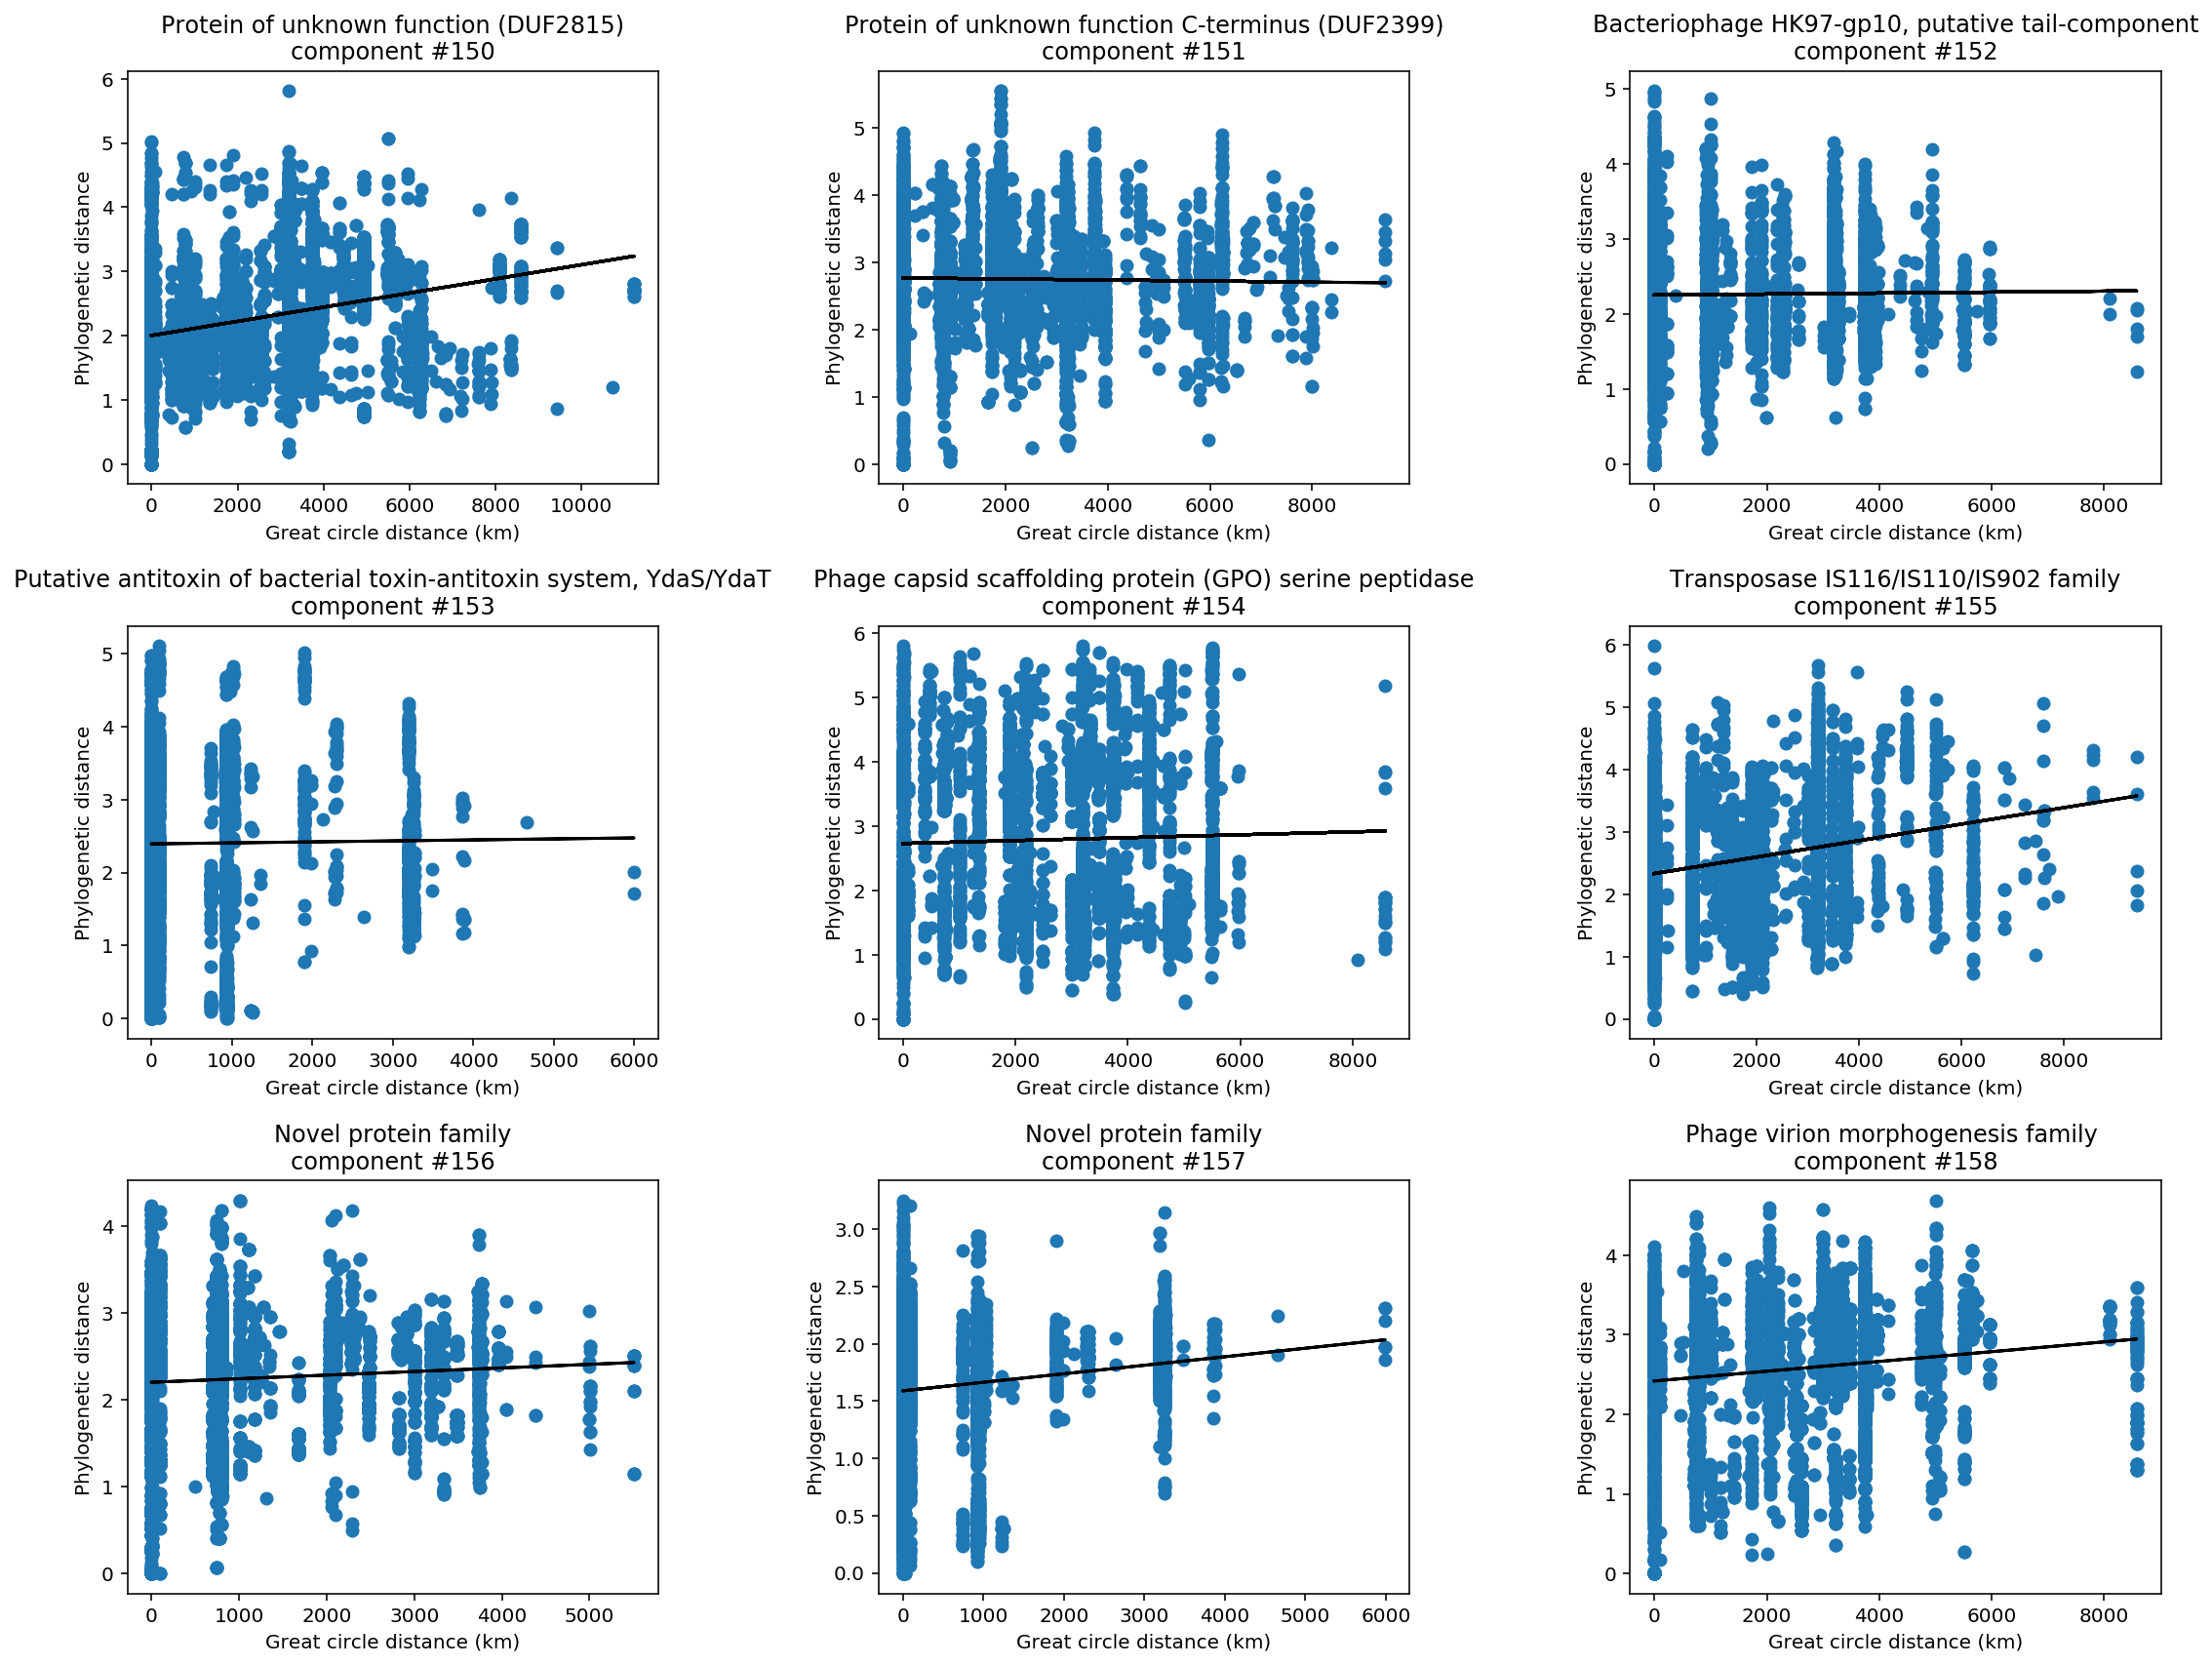

In [30]:
fig = plt.figure(figsize=(16,12))


for n,i in enumerate( range( 150, 150+9 ) ) :
    tree = trees[i]
    subplot( 3, 3, n+1 )
    #title( ' : '.join( map( str, ('size', len(g) ) ) ) )
    title( pfam_annotation(i) + '\ncomponent #' + str(i) )

    phylodist = tree.distances_by_name( list( combinations( tree.leafs.keys(), 2 ) ) )
    geodist = array( list( geo_distance_pairs( tree, gradient='full' ) ) )
    
    # index of not-nan values
    idx = np.isfinite( geodist ) & np.isfinite( phylodist )
    
    fit = np.polyfit( geodist[idx], phylodist[idx], 1 )
    fit_fn = np.poly1d( fit ) 
    # fit_fn is now a function which takes in x and returns an estimate for y
        
    scatter( geodist, phylodist )
    
    plot( geodist, fit_fn(geodist), color='black' )

    xlabel( 'Great circle distance (km)' )
    ylabel( 'Phylogenetic distance' )

    
tight_layout()

savefig( 'component_correlations.svg' )

slope     : 0.00011009119037485987
intercept : 2.0020691421867136
R^2       : 0.08850246995385894
p         : 1.7132113972110645e-129
sterr     : 4.442096881881476e-06


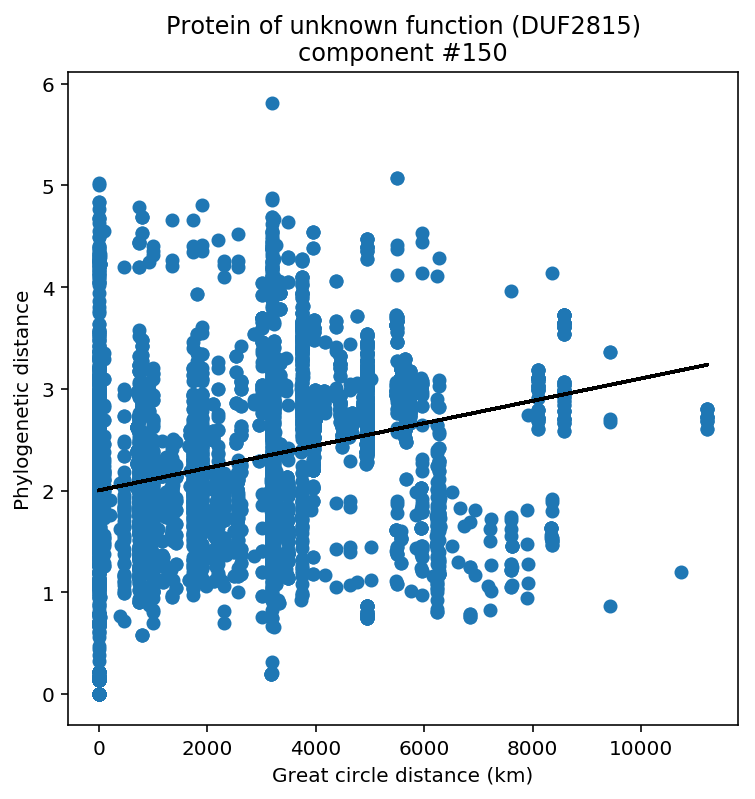

In [33]:
# Figure graphic

figure( figsize=(6,6) )

i = 150

tree = trees[i]

title( pfam_annotation(i) + '\ncomponent #' + str(i) )

phylodist = tree.distances_by_name( list( combinations( tree.leafs.keys(), 2 ) ) )
geodist = array( list( geo_distance_pairs( tree, gradient='full' ) ) )
    
# index of not-nan values
idx = np.isfinite( geodist ) & np.isfinite( phylodist )

fit = np.polyfit( geodist[idx], phylodist[idx], 1 )
fit_fn = np.poly1d( fit ) 
# fit_fn is now a function which takes in x and returns an estimate for y

slope, intercept, r_value, p_value, std_err = linregress( geodist[idx], phylodist[idx] )

print( 'slope     : {slope}'.format(   slope   = slope      ) )
print( 'intercept : {i}'.format(       i       = intercept  ) )
print( 'R^2       : {r2}'.format(      r2      = r_value**2 ) )
print( 'p         : {p}'.format(       p       = p_value    ) )
print( 'sterr     : {std_err}'.format( std_err = std_err    ) )

scatter( geodist, phylodist )

plot( geodist, fit_fn(geodist), color='black' )

xlabel( 'Great circle distance (km)' )
ylabel( 'Phylogenetic distance' )

savefig( 'fig3b.pdf' )

In [32]:
len(correlations[ correlations.reject == True ].correlation)

1046

## Discordant phylogenomic biogeography

In [38]:
p = pyprind.ProgBar( len(components), 'mapping viral scaffolds to graph components...' )

components_to_scaffolds = {}
scaffolds_to_components = {}

with open( 'components_to_scaffolds.tsv', 'w' ) as f1, \
     open( 'scaffolds_to_components.tsv', 'w' ) as f2 :
    for i,c in enumerate( components ) :
        p.update()
        viral_scaffolds = set( '_____'.join( name.split('_____')[:2] ) for name in c )
        components_to_scaffolds[i] = viral_scaffolds
        f1.write( '{i}\t{s}\n'.format( i=str(i), s=','.join(viral_scaffolds) ) )
        for vs in viral_scaffolds :
            if not vs in scaffolds_to_components :
                scaffolds_to_components[vs] = []
            scaffolds_to_components[vs].append( i )
    for vs,c in scaffolds_to_components.items() :
        f2.write( '{vs}\t{c}\n'.format( vs=vs, c=','.join(map(str,c) ) ) )

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


In [39]:
p = pyprind.ProgBar( len(scaffolds_to_components.keys()), 'calculating net genomic biogeographic signal...' )

scaffold_stats = {}
for scaffold_name in scaffolds_to_components.keys() :
    
    p.update()
    
    scaffstats = {}
    
    c = scaffolds_to_components[ scaffold_name ]
    scaffstats['components'] = len(c)
    
    c_indexed = [ n for n in c if n>0 and n<10000 ]
    scaffstats['components_indexed'] = len(c_indexed)
    
    cpntcors = correlations.loc[ c_indexed ]
    
    if cpntcors.shape[0] > 0 :
        cpntsig = cpntcors[ cpntcors.corrected_p < 0.05 ]
        scaffstats['components_significant'] = cpntsig.shape[0]
        scaffstats['mean_correlation'] = mean( cpntsig.correlation )
        scaffstats['std_correlation'] = std( cpntsig.correlation )
    
    scaffold_stats[scaffold_name] = scaffstats

scaffold_stats = pandas.DataFrame( scaffold_stats ).T
scaffold_stats['fraction_significant'] = scaffold_stats['components_significant'] / scaffold_stats['components']

scaffold_stats.head()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:35


components  \
2088090008_____P3_DRAFT_NODE_290175_len_15711_c...         8.0   
2088090014_____GPIPI_16496951                              6.0   
2088090014_____GPIPI_16499693                              4.0   
2088090014_____GPIPI_16580710                              2.0   
2088090014_____GPIPI_16694453                              3.0   

                                                    components_indexed  \
2088090008_____P3_DRAFT_NODE_290175_len_15711_c...                 2.0   
2088090014_____GPIPI_16496951                                      5.0   
2088090014_____GPIPI_16499693                                      1.0   
2088090014_____GPIPI_16580710                                      0.0   
2088090014_____GPIPI_16694453                                      2.0   

                                                    components_significant  \
2088090008_____P3_DRAFT_NODE_290175_len_15711_c...                     0.0   
2088090014_____GPIPI_16496951                                          3.0   
2088090014_____GPIPI_16499693                                          0.0   
2088090014_____GPIPI_16580710                                          NaN   
2088090014_____GPIPI_16694453                                          1.0   

                                                    mean_correlation  \
2088090008_____P3_DRAFT_NODE_290175_len_15711_c...               NaN   
2088090014_____GPIPI_16496951                               0.179794   
2088090014_____GPIPI_16499693                                    NaN   
2088090014_____GPIPI_16580710                                    NaN   
2088090014_____GPIPI_16694453                              -0.042042   

                                                    std_correlation  \
2088090008_____P3_DRAFT_NODE_290175_len_15711_c...              NaN   
2088090014_____GPIPI_16496951                              0.119783   
2088090014_____GPIPI_16499693                                   NaN   
2088090014_____GPIPI_16580710                                   NaN   
2088090014_____GPIPI_16694453                              0.000000   

                                                    fraction_significant  
2088090008_____P3_DRAFT_NODE_290175_len_15711_c...              0.000000  
2088090014_____GPIPI_16496951                                   0.500000  
2088090014_____GPIPI_16499693                                   0.000000  
2088090014_____GPIPI_16580710                                        NaN  
2088090014_____GPIPI_16694453                                   0.333333

In [40]:
scaffold_stats['fraction_significant'] = scaffold_stats['components_significant'] / scaffold_stats['components']
scaffold_stats.head()

components  \
2088090008_____P3_DRAFT_NODE_290175_len_15711_c...         8.0   
2088090014_____GPIPI_16496951                              6.0   
2088090014_____GPIPI_16499693                              4.0   
2088090014_____GPIPI_16580710                              2.0   
2088090014_____GPIPI_16694453                              3.0   

                                                    components_indexed  \
2088090008_____P3_DRAFT_NODE_290175_len_15711_c...                 2.0   
2088090014_____GPIPI_16496951                                      5.0   
2088090014_____GPIPI_16499693                                      1.0   
2088090014_____GPIPI_16580710                                      0.0   
2088090014_____GPIPI_16694453                                      2.0   

                                                    components_significant  \
2088090008_____P3_DRAFT_NODE_290175_len_15711_c...                     0.0   
2088090014_____GPIPI_16496951                                          3.0   
2088090014_____GPIPI_16499693                                          0.0   
2088090014_____GPIPI_16580710                                          NaN   
2088090014_____GPIPI_16694453                                          1.0   

                                                    mean_correlation  \
2088090008_____P3_DRAFT_NODE_290175_len_15711_c...               NaN   
2088090014_____GPIPI_16496951                               0.179794   
2088090014_____GPIPI_16499693                                    NaN   
2088090014_____GPIPI_16580710                                    NaN   
2088090014_____GPIPI_16694453                              -0.042042   

                                                    std_correlation  \
2088090008_____P3_DRAFT_NODE_290175_len_15711_c...              NaN   
2088090014_____GPIPI_16496951                              0.119783   
2088090014_____GPIPI_16499693                                   NaN   
2088090014_____GPIPI_16580710                                   NaN   
2088090014_____GPIPI_16694453                              0.000000   

                                                    fraction_significant  
2088090008_____P3_DRAFT_NODE_290175_len_15711_c...              0.000000  
2088090014_____GPIPI_16496951                                   0.500000  
2088090014_____GPIPI_16499693                                   0.000000  
2088090014_____GPIPI_16580710                                        NaN  
2088090014_____GPIPI_16694453                                   0.333333

In [41]:
interesting_scaffolds = scaffold_stats[ (scaffold_stats.components > 10) & 
                                        (scaffold_stats.fraction_significant > 0.5 ) &
                                        (abs(scaffold_stats.mean_correlation) > 0.1 ) ]

interesting_scaffolds.to_csv( 'biogeo_scaffolds.csv' )
interesting_scaffolds

components  \
3300000651_____AP72_2010_repI_A10DRAFT_1000006        17.0   
3300001686_____C688J18823_10000309                    11.0   
3300002538_____JGI24132J36420_10000213                40.0   
3300002839_____JGIcombinedJ43158_10000979             23.0   
3300002907_____JGI25613J43889_10000114                11.0   
3300003911_____JGI25405J52794_10000255                13.0   
3300005336_____Ga0070680_100000047                    22.0   
3300005406_____Ga0070703_10000394                     17.0   
3300005435_____Ga0070714_100005555                    15.0   
3300005436_____Ga0070713_100003734                    16.0   
3300005436_____Ga0070713_100011231                    12.0   
3300005437_____Ga0070710_10002062                     11.0   
3300005468_____Ga0070707_100000863                    13.0   
3300005518_____Ga0070699_100002343                    11.0   
3300005587_____Ga0066654_10003567                     12.0   
3300005834_____Ga0068851_10001283                     11.0   
3300005937_____Ga0081455_10016604                     13.0   
3300006173_____Ga0070716_100001532                    11.0   
3300006173_____Ga0070716_100001551                    16.0   
3300006175_____Ga0070712_100004808                    13.0   
3300006844_____Ga0075428_100006274                    12.0   
3300006845_____Ga0075421_100000270                    17.0   
3300006969_____Ga0075419_10001245                     14.0   
3300009090_____Ga0099827_10000710                     11.0   
3300009176_____Ga0105242_10001355                     11.0   
3300010048_____Ga0126373_10001596                     11.0   
3300010361_____Ga0126378_10003330                     11.0   
3300010366_____Ga0126379_10000767                     11.0   
3300010366_____Ga0126379_10001204                     13.0   
3300011119_____Ga0105246_10001907                     11.0   
3300012207_____Ga0137381_10003049                     12.0   
3300012207_____Ga0137381_10011741                     12.0   
3300012211_____Ga0137377_10009087                     12.0   
3300012351_____Ga0137386_10008427                     12.0   
3300012359_____Ga0137385_10028083                     11.0   
3300012361_____Ga0137360_10001783                     11.0   
3300012971_____Ga0126369_10003829                     11.0   
3300013100_____Ga0157373_10005070                     11.0   
3300013306_____Ga0163162_10001364                     13.0   
3300014326_____Ga0157380_10000675                     14.0   
3300014497_____Ga0182008_10001500                     11.0   
3300015262_____Ga0182007_10000153                     11.0   
3300015265_____Ga0182005_1000144                      14.0   
3300018431_____Ga0066655_10000462                     17.0   

                                                components_indexed  \
3300000651_____AP72_2010_repI_A10DRAFT_1000006                16.0   
3300001686_____C688J18823_10000309                            10.0   
3300002538_____JGI24132J36420_10000213                        32.0   
3300002839_____JGIcombinedJ43158_10000979                     17.0   
3300002907_____JGI25613J43889_10000114                         9.0   
3300003911_____JGI25405J52794_10000255                         8.0   
3300005336_____Ga0070680_100000047                            20.0   
3300005406_____Ga0070703_10000394                             14.0   
3300005435_____Ga0070714_100005555                            10.0   
3300005436_____Ga0070713_100003734                            15.0   
3300005436_____Ga0070713_100011231                             8.0   
3300005437_____Ga0070710_10002062                             10.0   
3300005468_____Ga0070707_100000863                            10.0   
3300005518_____Ga0070699_100002343                             9.0   
3300005587_____Ga0066654_10003567                             11.0   
3300005834_____Ga0068851_10001283                             10.0   
3300005937_____Ga0081455_10016604                              8.0 

(10.449999999999999, 44.549999999999997, -10.75, 225.75)

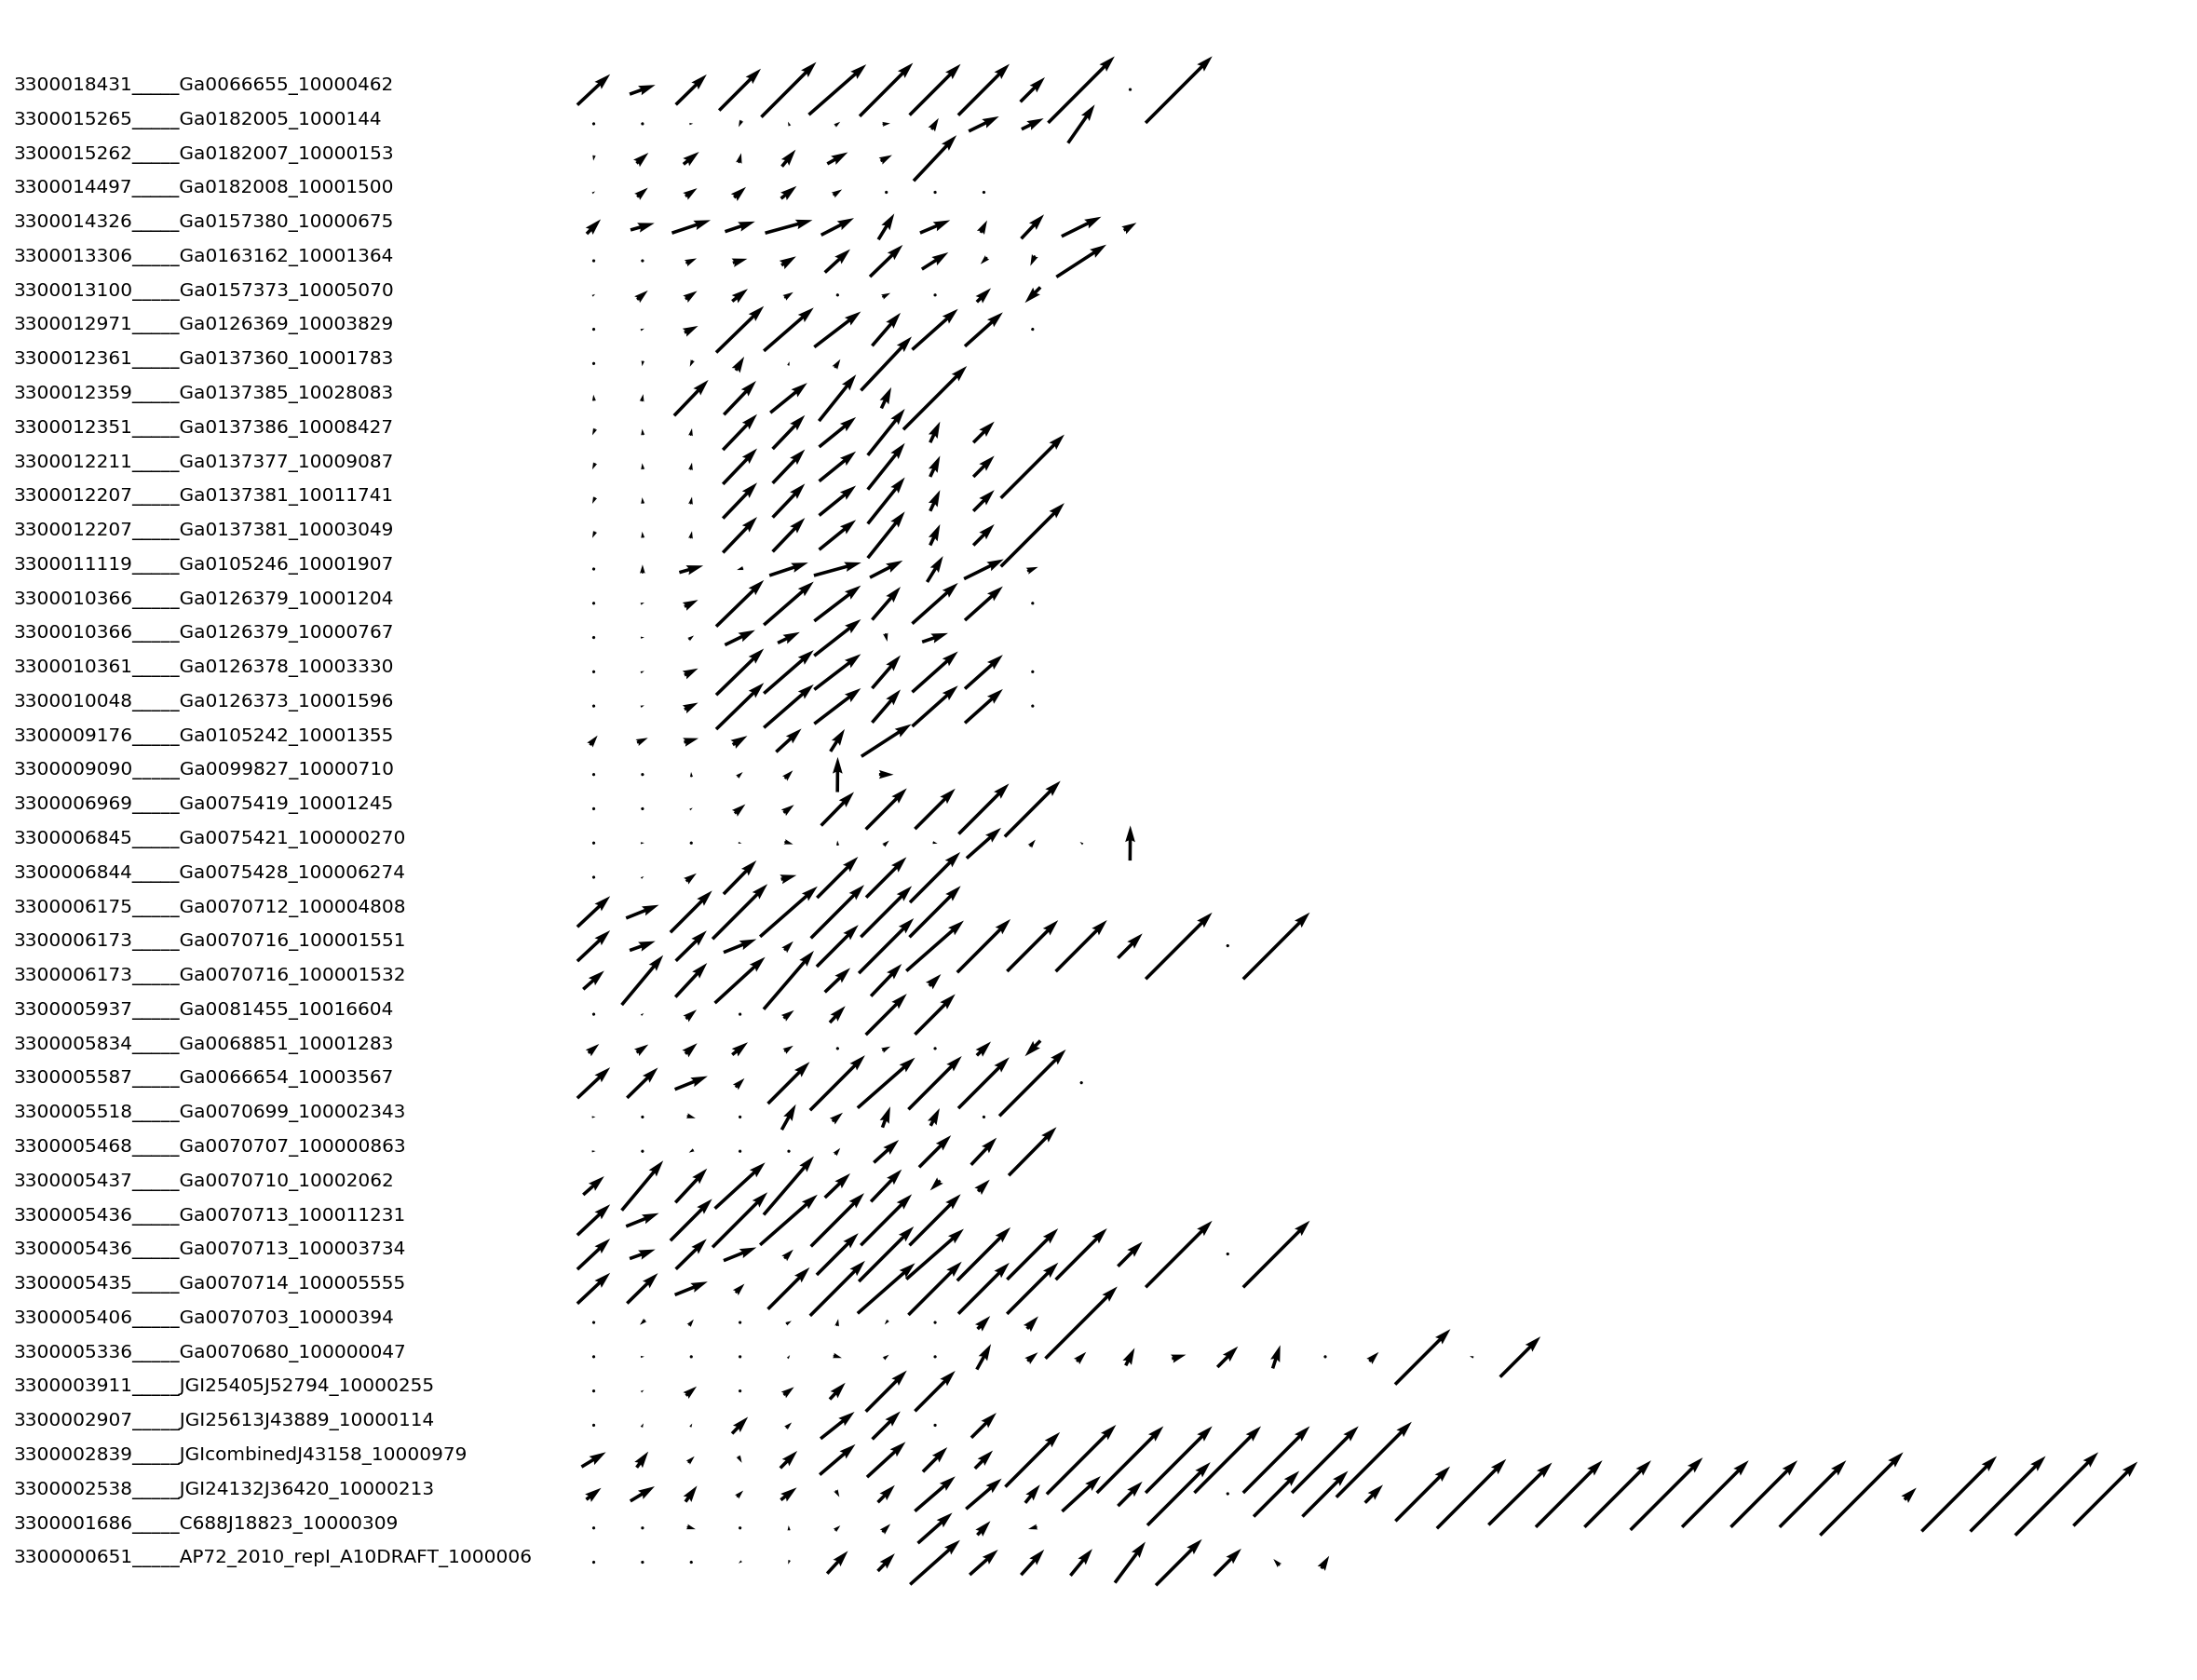

In [46]:
figure( figsize=(16,16) )

for i,scaffold_name in enumerate(interesting_scaffolds.index) :
    
    c = [ i for i in scaffolds_to_components[scaffold_name] if i>0 and i<10000 ]
    
    scaffdata = correlations.loc[ c ].dropna()
    
    quiver( range(12,scaffdata.shape[0]+12), # horizontal position
            [i*5]*scaffdata.shape[0],      # vertical positon
            scaffdata.correlation_ns,      # north-south component
            scaffdata.correlation_ew,      # east-west componet
            pivot='middle', scale=20, width=0.002 )
    
    text( 0.1, i*5, scaffold_name )
    
#xlim( 0, max(interesting_scaffolds.components) )
axis('off')

In [47]:
progbar = pyprind.ProgBar( len(components), 'creating maps...' )

genes_to_components = {}
components_to_genes = {}
for n,c in enumerate(components) :
    progbar.update()
    for gene in c.nodes :
        genes_to_components[gene] = n
        if not n in components_to_genes :
            components_to_genes[n] = set()
        components_to_genes[n].add(gene)

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


In [48]:
progbar = pyprind.ProgBar( len(G.nodes), 'building gene table...' )

gene_table = []
for node in G.nodes :
    progbar.update()
    
    gene_name = str(node)
    taxon, scaffold, gene = gene_name.split('_____')
    
    c = genes_to_components[gene_name]
    
    # skip the giant hairball -- it takes forever and
    # doesn't have a meaningful annotation anyway
    if c == 0 :
        annotation = None
    else :
        annotation = pfam_annotation(c)
    
    gene_table.append( { 'gene'         : gene_name,
                         'component'    : c,
                         'taxon_oid'    : taxon,
                         'scaffold_oid' : scaffold,
                         'gene_oid'     : gene,
                         'annotation'   : annotation } )
    
gene_table = pandas.DataFrame( gene_table )
gene_table.head()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:43


annotation  component                                               gene  \
0       None          0  2088090008_____P3_DRAFT_NODE_290175_len_15711_...   
1       None          0  3300002243_____C687J29039_10000481_____C687J29...   
2       None          0  3300014493_____Ga0182016_10005848_____Ga018201...   
3       None          0  3300006638_____Ga0075522_10000183_____Ga007552...   
4       None          0  3300001160_____JGI12654J13325_1000002_____JGI1...   

                   gene_oid                                  scaffold_oid  \
0         P3_DRAFT_00194830  P3_DRAFT_NODE_290175_len_15711_cov_24_196932   
1     C687J29039_1000048124                           C687J29039_10000481   
2      Ga0182016_1000584818                            Ga0182016_10005848   
3       Ga0075522_100001835                            Ga0075522_10000183   
4  JGI12654J13325_100000227                        JGI12654J13325_1000002   

    taxon_oid  
0  2088090008  
1  3300002243  
2  3300014493  
3  3300006638  
4  3300001160

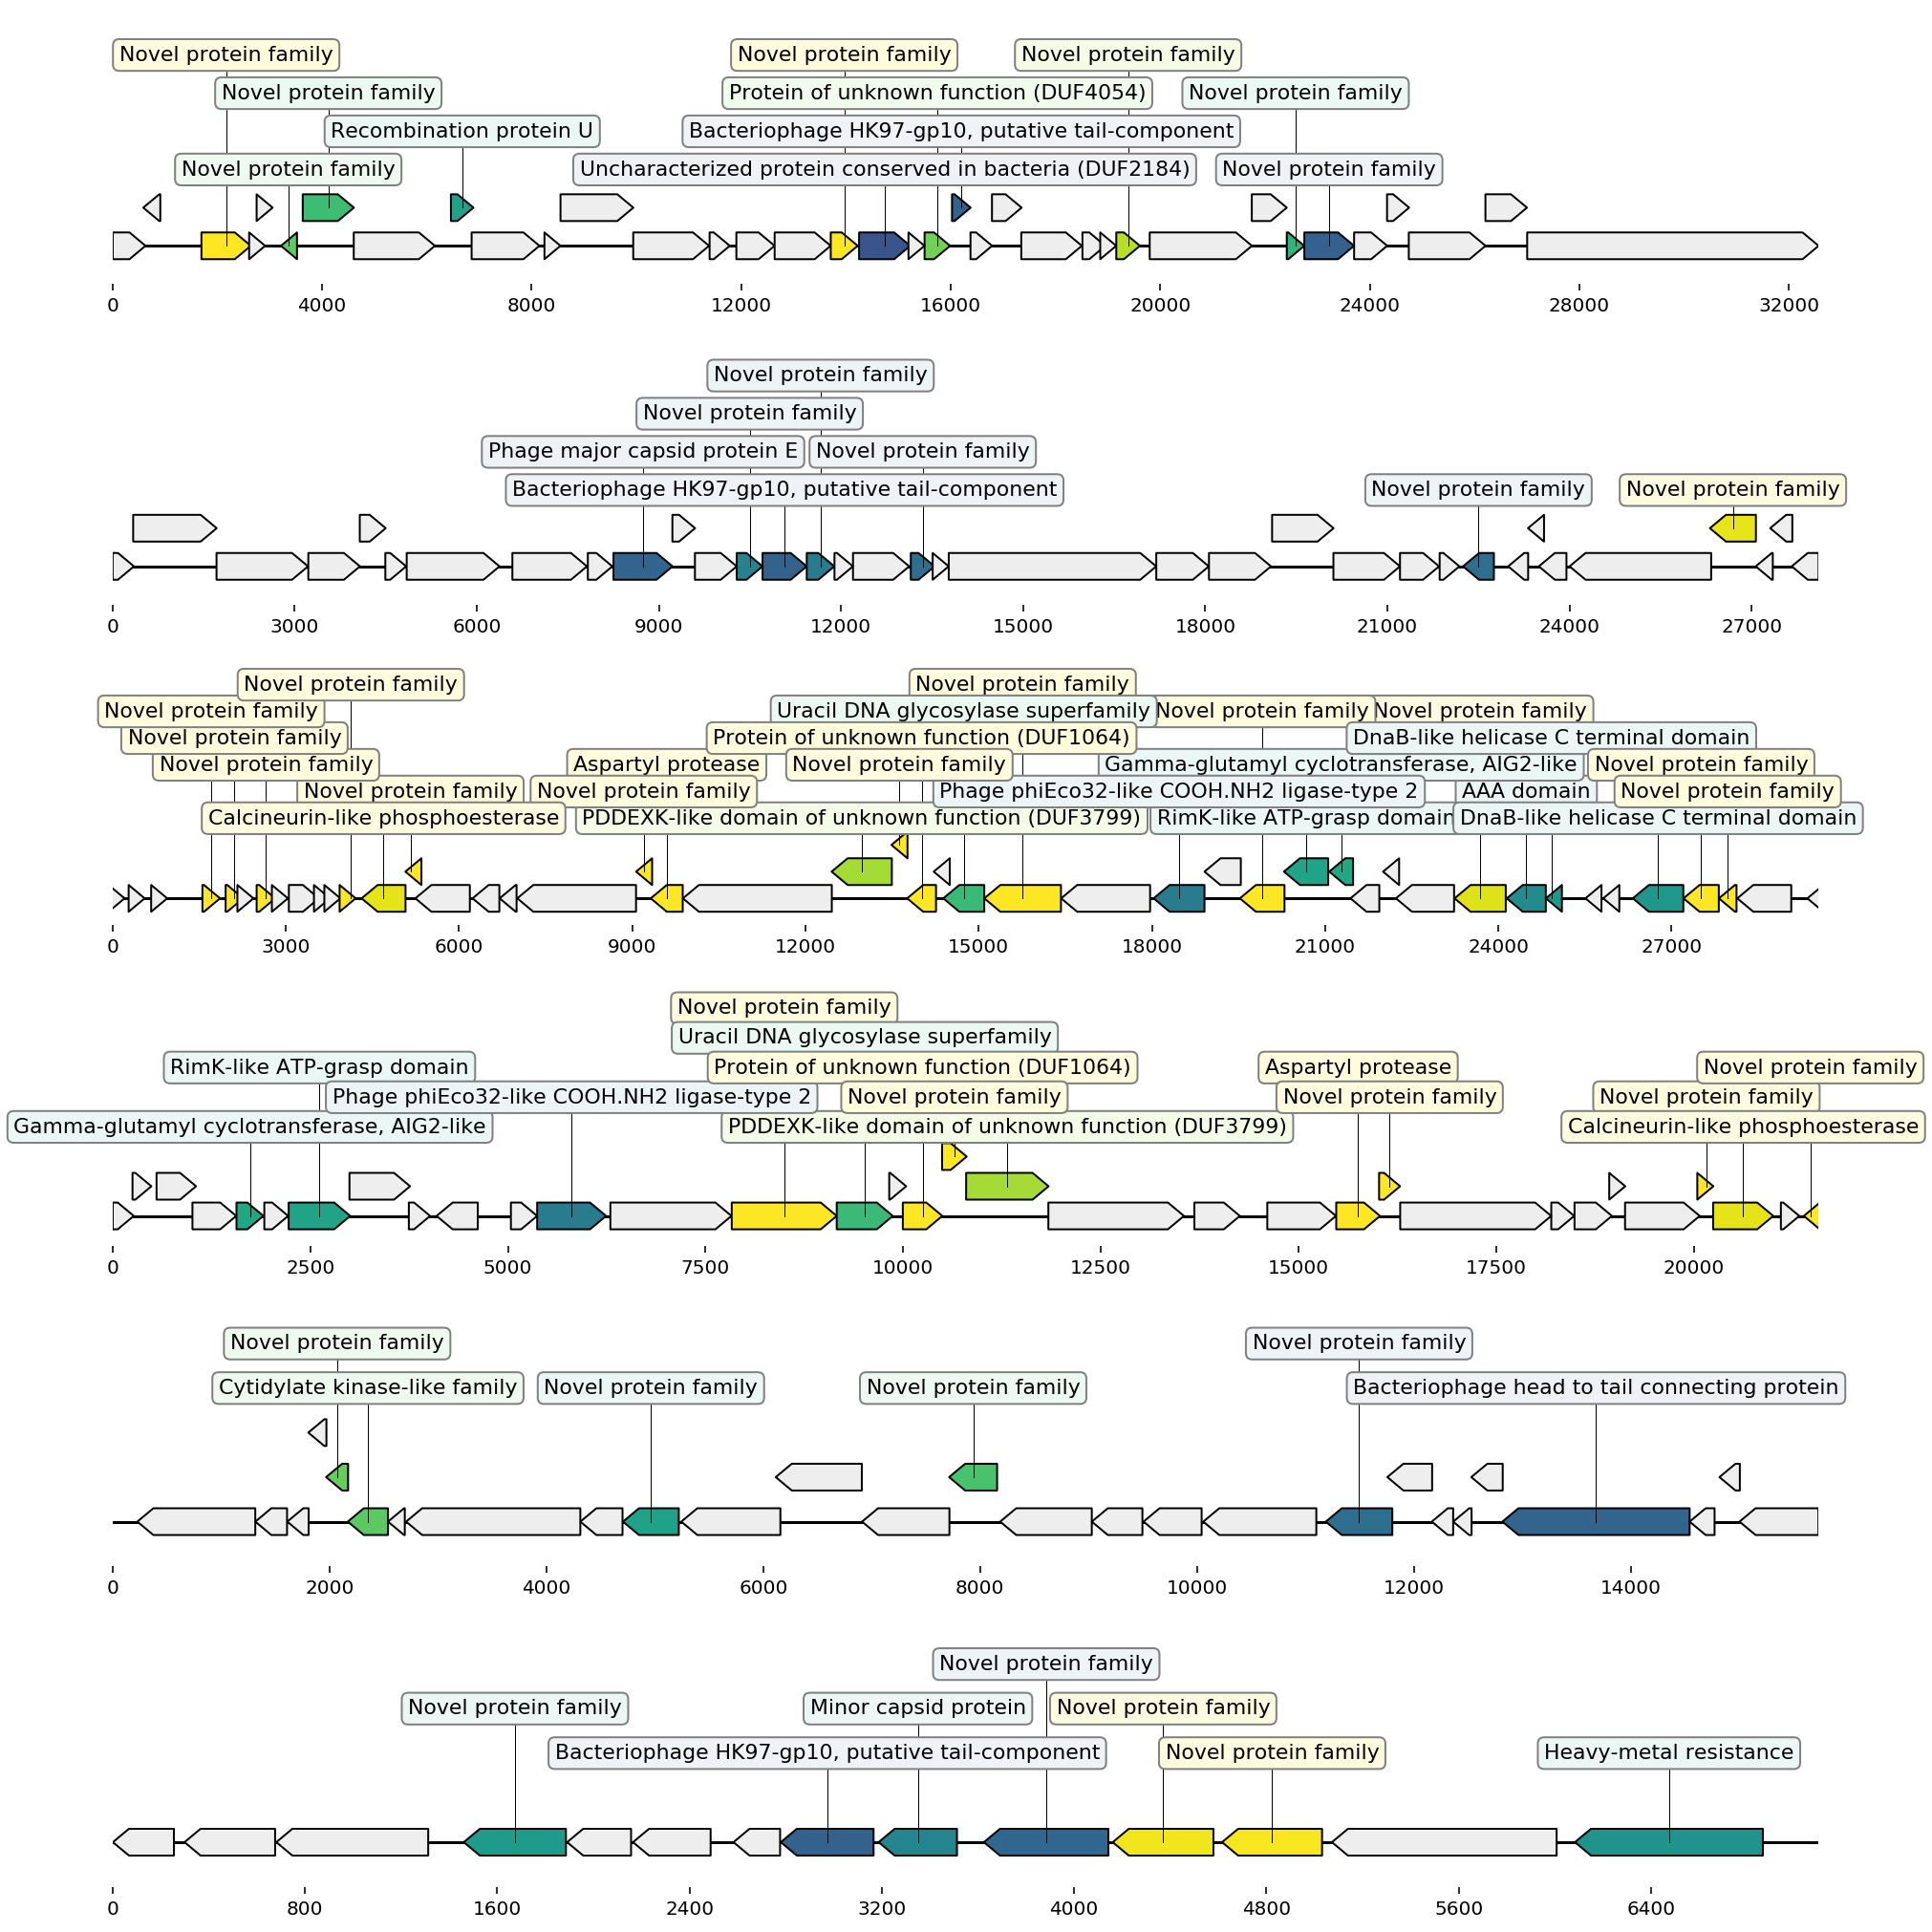

In [49]:
import sqlite3
import os.path
from dna_features_viewer import GraphicFeature, GraphicRecord


NERSC_prefix = '/global/dna/projectdirs/microbial/img_web_data_merfs/'

def get_scaffold_stats( taxon, scaffold ) :
    scaffdb_path = os.path.join( NERSC_prefix, taxon, 'assembled', 'scaffold_stats.sdb' )
    if os.path.exists( scaffdb_path ) :
        conn = sqlite3.connect( scaffdb_path )
        scaff_df = pandas.read_sql_query( 'select * from scaffold_stats where scaffold_oid=:oid;', 
                                          conn, params={'oid':scaffold} )

        return scaff_df
    else :
        raise Exception( 'Could not find scaffold {} for taxon {}'.format( scaffold, taxon ) )

def get_scaffold_genes( taxon, scaffold ) :
    scaffdb_path = os.path.join( NERSC_prefix, taxon, 'assembled', 'scaffold_genes' )
    if os.path.exists( scaffdb_path ) :
        for dbfile in os.listdir( scaffdb_path ) :
            conn = sqlite3.connect( os.path.join( scaffdb_path, dbfile ) )
            
            scaff_df = pandas.read_sql_query( 'select * from scaffold_genes where scaffold_oid=:oid;', 
                                              conn, params={'oid':scaffold} )
            
            scaff_df['gene'] = [ '_____'.join( map( str, [ taxon, 
                                                           row.scaffold_oid,
                                                           row.gene_oid ] ) ) 
                                 for n,row in scaff_df.iterrows() ]
                        
            if scaff_df.shape[0] :
                return scaff_df

figure( figsize=(16,18) )

# colors are approximately normalized to the histogram of significant
# correlations, with a saturation point at tau = 0.5
norm = matplotlib.colors.Normalize( vmin=-0.2, vmax=0.5)

for i,(name,row_interesting) in enumerate( interesting_scaffolds.iterrows() ) :
    
    if i > 5 : break
    
    taxon, scaffold = name.split('_____')
    
    scaff_stats = get_scaffold_stats( taxon, scaffold )
    scaff_genes = get_scaffold_genes( taxon, scaffold )
    
    df1 = pandas.merge( gene_table[['gene','annotation','component']],
                        scaff_genes, 
                        on='gene', how='right').join( correlations, on='component' )
    
    features = []
    for n,row in df1.iterrows() :
        
        if row.reject == True :
            #color = '#ffcccc'
            color = matplotlib.colors.rgb2hex( cmap( norm( row.correlation ) ) )
            annotation = row.annotation
        else :
            color = '#eeeeee'
            annotation = None
                        
        if row.strand == '+' :
            strand = +1 
        else :
            strand = -1
        
        features.append( GraphicFeature( start  = row.start_coord,
                                         end    = row.end_coord, 
                                         strand = strand,
                                         color  = color,
                                         label  = annotation ) )

    #subplot(1,interesting_scaffolds.shape[0],i+1)
    ax = subplot( 6, 1, i+1 )
    record = GraphicRecord(sequence_length=scaff_stats.loc[0].length, features=features)
    #ax = axes()
    gp = record.plot(ax, figure_width=30)
    
savefig( 'biogeo_scaffolds.png' )

## References

<div class="cite2c-biblio"></div>